In [57]:
from functions import *


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import pandas as pd

from skimage.feature import blob_log
import skimage
import scipy.signal as signal

from apsg import *



microm2m = 1.0E-6
m2microm = 1.0E6
plt.rcParams["figure.figsize"] = (10,10)

In [168]:
flight = 5.0  # sample-sensor distance
area = (0, 1400*microm2m, 0, 2000*microm2m)
shape = (1000,1000)
z = -flight*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


# generates x shallow sourcers
sourcers = 100
D_1 = np.random.normal(0, 15, sourcers)
I_1 = np.random.normal(0, 15, sourcers)
Q_1 = np.random.normal(20000, 5000, sourcers)
R_1 = ( np.random.normal(0.5, 0.2, sourcers) )*microm2m

Xc_1 = np.random.randint(30, 1370, sourcers)*microm2m
Yc_1 = np.random.randint(30, 1970, sourcers)*microm2m
Zc_1 = np.random.randint(1, 20, sourcers)*microm2m


# generates x deep sourcers
sourcers = 10
D_2 = np.random.normal(0, 180, sourcers)
I_2 = np.random.normal(0, 90, sourcers)
Q_2 = np.random.normal(20000, 5000, sourcers)
R_2 = ( np.random.normal(10.5, 0.1, sourcers) )*microm2m

Xc_2 = np.random.randint(30, 1370, sourcers)*microm2m
Yc_2 = np.random.randint(30, 1970, sourcers)*microm2m
Zc_2 = np.random.randint(500, 550, sourcers)*microm2m

# concat sources
D = np.concatenate((D_1, D_2))
I = np.concatenate((I_1, I_2))
Q = np.concatenate((Q_1, Q_2))
R = np.concatenate((R_1, R_2))

Xc = np.concatenate((Xc_1, Xc_2))
Yc = np.concatenate((Yc_1, Yc_2))
Zc = np.concatenate((Zc_1, Zc_2))


m = cartesian_components(D, I, Q, R)
M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)


In [169]:
# data vector direct model
d = np.matmul(M, m)

#apply noise
#error = 0.05   # % for the 'max amplitude method'
error = 5.0e-9 # nT for the 'fixed method'

d = noise(d, error=error, method='fixed')

# Reshape data vector for the map plot
d_= np.reshape(d, shape)

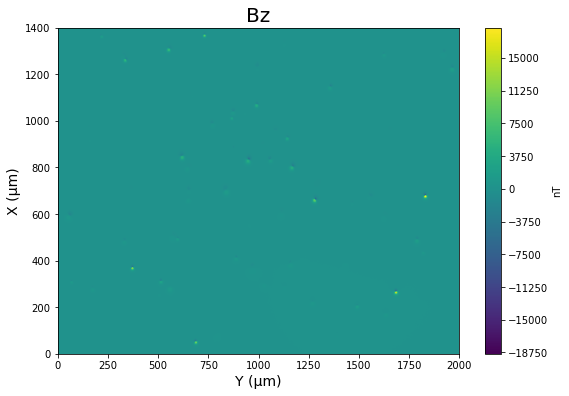

In [189]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm



# Plot data from the forward model
plt.figure(figsize=(9,6))
plt.contourf(x_plot, y_plot, d_*10**9, levels=300, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.show()

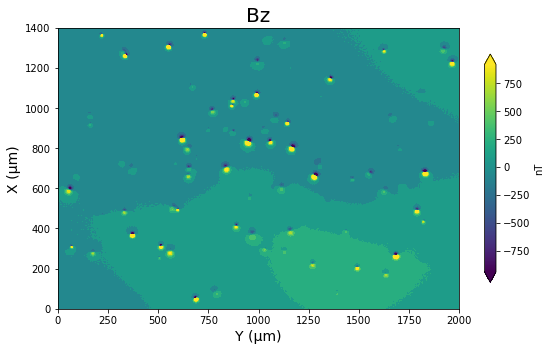

In [188]:
# Change the colorbar scale
# Plot data from the forward model
vmin=np.min(d_*10**9) * 0.05
vmax=np.max(d_*10**9) * 0.05


plt.figure(figsize=(9,6))
fig = plt.imshow(d_*10**9, cmap='viridis')
plt.clim(vmin, vmax)

plt.contourf(x_plot, y_plot, d_*10**9, levels=300, cmap='viridis', 
             vmin=vmin, vmax=vmax, extend='both')
color_bar = plt.colorbar(fig, label='nT', extend='both', shrink=0.7)

plt.gca().invert_yaxis()


plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



plt.show()



In [5]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(d_, X_, Y_)

ddx = x_derivative_fft(d_, wx, order=1)
ddy = y_derivative_fft(d_, wy, order=1)
ddz = z_derivative_fft(d_, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
d_X, d_Y = (derivative_fd(d_, X_,Y_, order=1))


Text(0, 0.5, 'X (µm)')

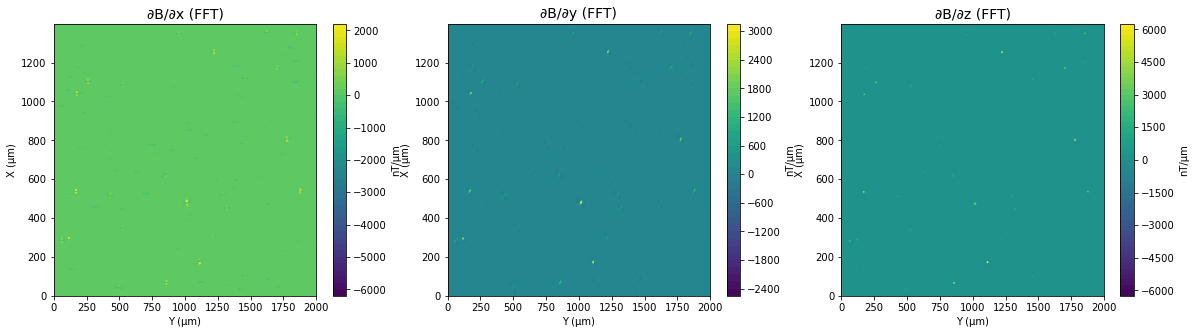

In [6]:
# plot FFT derivatives
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], ddx[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FFT)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot  = ax2.contourf(x_plot[::2], y_plot[::2], ddy[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FFT)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot  = ax3.contourf(x_plot[::2], y_plot[::2], ddz[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FFT)', fontsize=14)
ax3.set_xlabel('Y (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)

Text(0, 0.5, 'X (µm)')

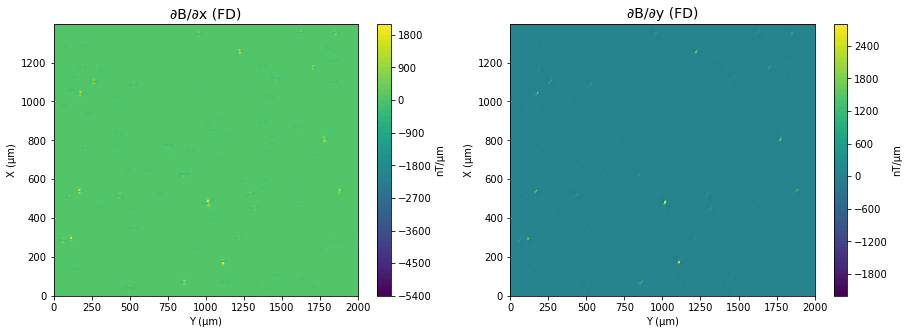

In [7]:
# plot FD derivatives
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], d_X[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FD)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], d_Y[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FD)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

In [8]:
# Calculating the horizontal gradient (GH) using FFT e FD

Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)

Text(0, 0.5, 'X (µm)')

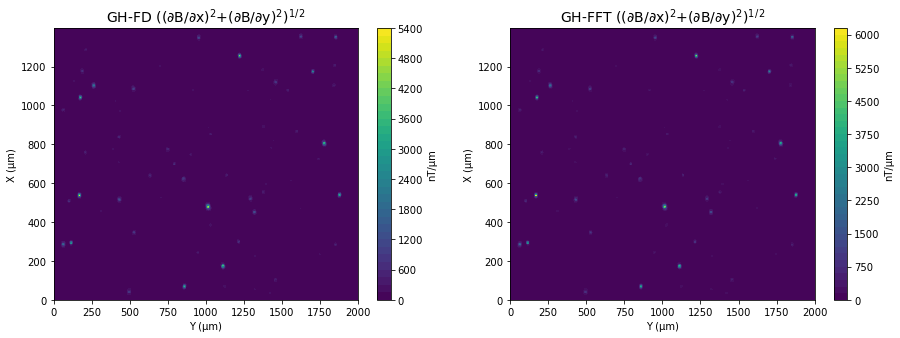

In [9]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FD[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FFT[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

In [10]:
# upward_continuation filtering --> to remove high frequency noise
height = 5.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(d_, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

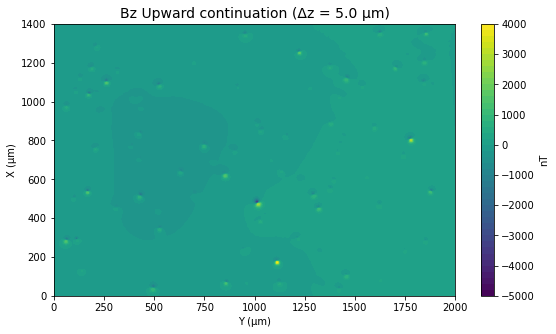

In [11]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=14)
plt.xlabel('Y (µm)', fontsize=10)
plt.ylabel('X (µm)', fontsize=10)



In [12]:
# New derivatives by FFT
ddy = y_derivative_fft(upward, wy)
ddx = x_derivative_fft(upward, wx)
ddz = z_derivative_fft(upward, wz)


Text(0, 0.5, 'X (µm)')

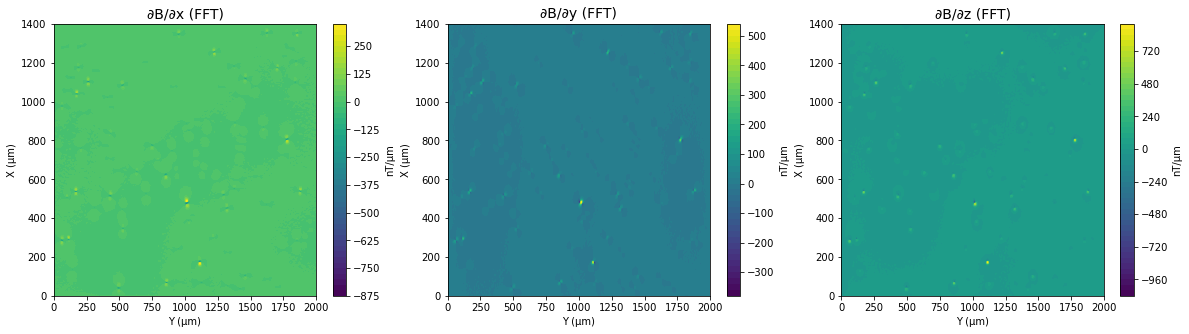

In [13]:
# Plot derivatives by FFT (after upward continuation)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot, y_plot, ddx*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FFT)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot  = ax2.contourf(x_plot, y_plot, ddy*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FFT)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot  = ax3.contourf(x_plot, y_plot, ddz*10**3, levels=50, cmap='viridis')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FFT)', fontsize=14)
ax3.set_xlabel('Y (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)


In [14]:
# New derivatives by FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))
d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

Text(0, 0.5, 'X (µm)')

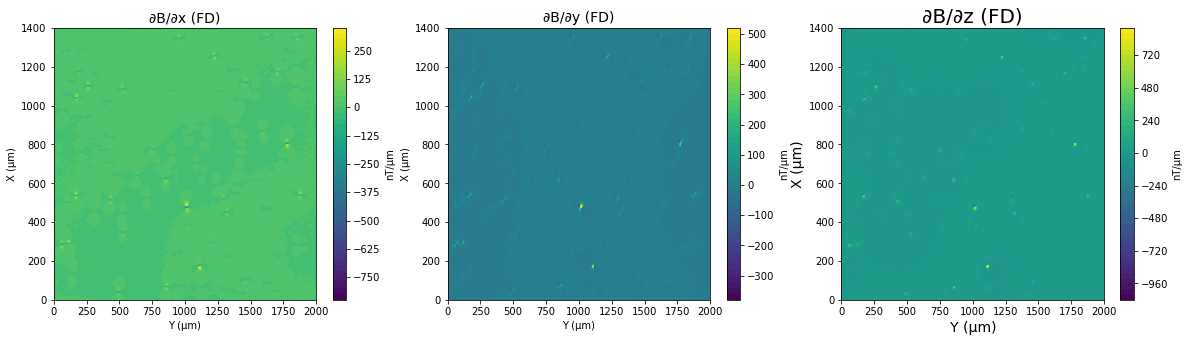

In [15]:
# Plot derivatives by FD (after upward continuation)
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot, y_plot, d_X*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FD)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot = ax2.contourf(x_plot, y_plot, d_Y*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FD)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot = ax3.contourf(x_plot, y_plot, d_Z*10**3, levels=50, cmap='viridis')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FD)', fontsize=20)
ax3.set_xlabel('Y (µm)', fontsize=14)
ax3.set_ylabel('X (µm)', fontsize=14)

In [16]:
# total gradient data
Total_Grad_FD = Total_Grad(d_Y , d_X, d_Z)
Total_Grad_FFT = Total_Grad(ddy, ddx, ddz)

Text(0, 0.5, 'X (µm)')

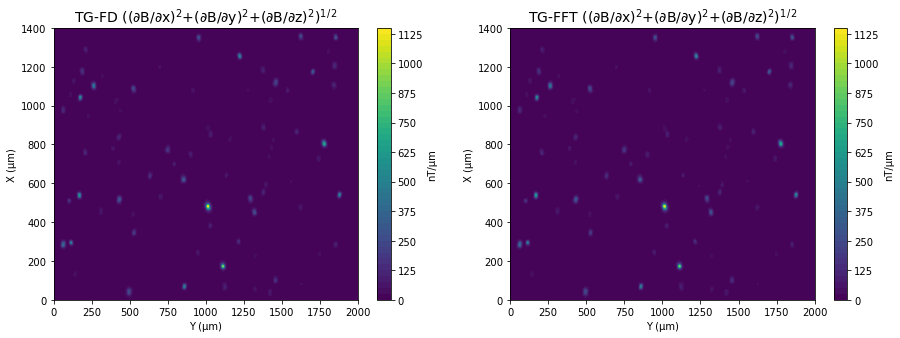

In [44]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# plot FD total gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, Total_Grad_FD*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('TG-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$+(∂B/∂z)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT total gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FFT*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('TG-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$+(∂B/∂z)$^2$)$^1$$^/$$^2$', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

# Euler solver

Text(0, 0.5, 'Count')

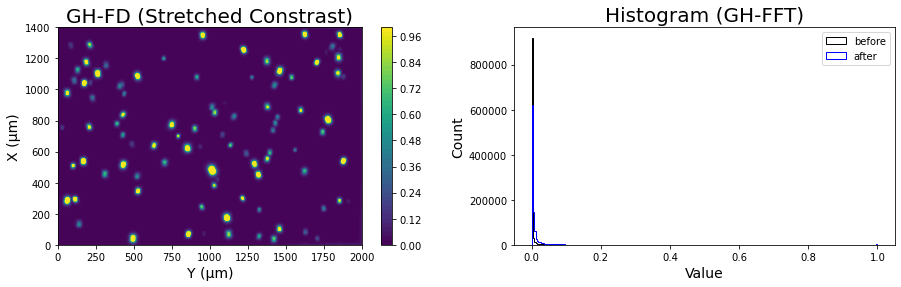

In [18]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (20.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='viridis')
ax1.set_title('GH-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (GH-FFT)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


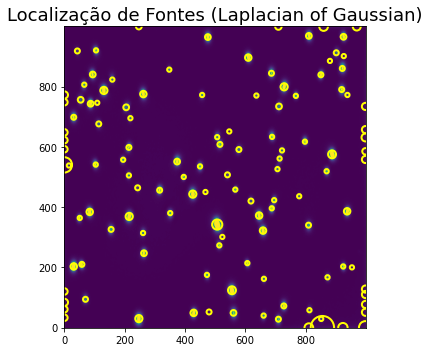

(94, 4)


()

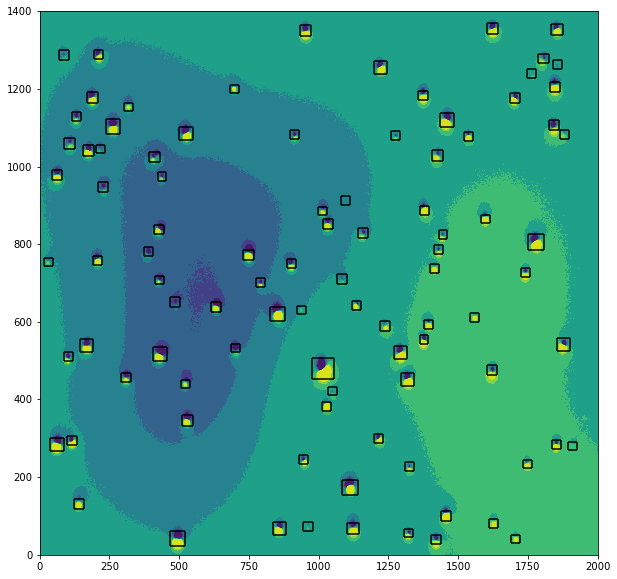

In [19]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.01, min_sigma=5, max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=0.1)
print(np.shape(euler_windows_FD))

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_, Y_, Z_, upward, d_X, d_Y, d_Z, delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(d_, (0.5,99.5))
view = skimage.exposure.rescale_intensity(d_, in_range=(perc_min, perc_max))
euler_windows_view(X_, Y_, Z_, view, filtered_euler_windows_FD, show_windows=False, color='k')


Euler Solutions:
      Xc (µm)    Yc (µm)  Zc (µm)
0    174.9725  1111.9955   3.1087
1    806.0070  1777.0263   3.1203
2    478.5306  1015.0640   4.3644
3   1255.9865  1221.9875   1.1187
4    540.0164  1877.9627   1.1432
..        ...        ...      ...
89    72.9651   961.9627   6.0640
90   284.8123  1914.3570   9.4887
91  1265.2748  1856.8572   6.7141
92  1240.1259  1773.1399   6.3584
93   907.2077  1104.6684   6.1546

[94 rows x 3 columns]

Original Positions:
    Xc (µm)  Yc (µm)  Zc (µm)
0    1103.0    263.0      3.0
1    1276.0   1805.0      9.0
2     634.0    936.0      7.0
3    1208.0   1846.0      8.0
4    1022.0    408.0      6.0
..      ...      ...      ...
95    493.0   1012.0      7.0
96   1058.0    109.0      9.0
97    347.0    528.0      4.0
98    360.0   1954.0      9.0
99   1120.0   1459.0      6.0

[100 rows x 3 columns]



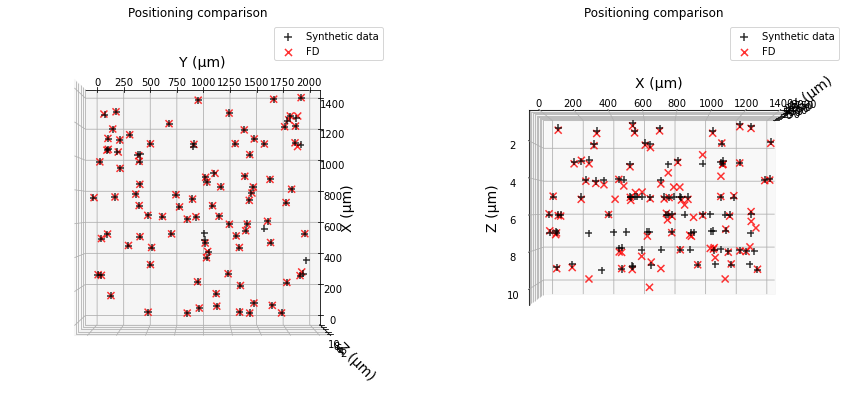

In [20]:
import pandas as pd
print('Euler Solutions:')
df1 = pd.DataFrame(data={'Xc (µm)': (np.round(Xc_FD*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_FD*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_FD*m2microm, decimals=4))
                       })

print(df1)
print()

print('Original Positions:')
df2 = pd.DataFrame(data={
                        'Xc (µm)': (np.round(Xc_1*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_1*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_1*m2microm, decimals=4))
                       })

print(df2)
print()

from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc_1*m2microm, Xc_1*m2microm, Zc_1*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90




ax2.scatter(Yc_1*m2microm, Xc_1*m2microm, Zc_1*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()





# Magnetic inversion using lest square method

Dec (°)  $\sigma D$ (°)  Inc (°)  $\sigma I$ (°)  m  ($A \cdot m^2$)  \
0 -14.8274          0.0064  38.1575          0.0042        5.753899e-14   
1 -22.9054          0.0052  13.3631          0.0036        5.808727e-14   
2 -25.9382          0.0030 -11.9593          0.0021        1.315145e-13   
3 -21.4184          0.0066   4.6881          0.0047        2.506163e-14   
4  19.3095          0.0073 -10.9553          0.0051        2.335107e-14   

   $\sigma m$ ($A \cdot m^2$)      Xc (µm)      Yc (µm)   Zc (µm)  
0                4.563674e-18   174.972457  1111.995522  3.108750  
1                5.019505e-18   806.006955  1777.026336  3.120318  
2                6.693631e-18   478.530633  1015.064017  4.364381  
3                2.883970e-18  1255.986503  1221.987495  1.118746  
4                2.885515e-18   540.016357  1877.962664  1.143185

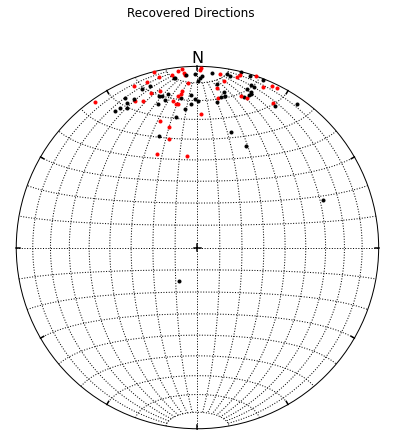

In [21]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation

# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
mx_FD_least, my_FD_least, mz_FD_least, M_FD_least, direct_model_FD_least = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)
D_FD_least, I_FD_least = directions(mx_FD_least, my_FD_least, mz_FD_least, plot=True)

#calculate momentum
momentum_FD_least = (np.sqrt(mx_FD_least**2 + my_FD_least**2 + mz_FD_least**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
sigma_noise = error
sigma_D_FD_least, sigma_I_FD_least, sigma_m_FD_least = uncertainties(sigma_noise, M_FD_least, mx_FD_least, my_FD_least, mz_FD_least)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)


# Article Figure

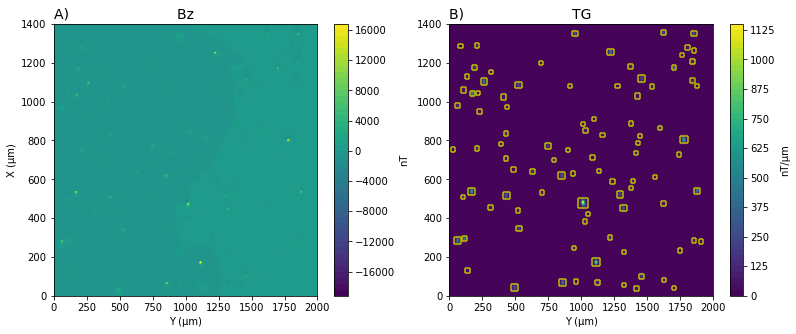

In [45]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(13,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, d_*10**9, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT')
ax1.set_title('A)                        Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FD*1.0e3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('B)                        TG', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)

# plot isolated windows 
nx, ny = np.shape(d_)
y_step = (np.max(Y_)*m2microm - np.min(Y_)*m2microm) / (ny-1)
x_step = (np.max(X_)*m2microm - np.min(X_)*m2microm) / (nx-1)
color='y'
for i in range(np.shape(euler_windows_FD)[0]):
    x1 = int(euler_windows_FD[i,0]) * x_step
    x2 = int(euler_windows_FD[i,1]) * x_step
    y1 = int(euler_windows_FD[i,2]) * y_step
    y2 = int(euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)


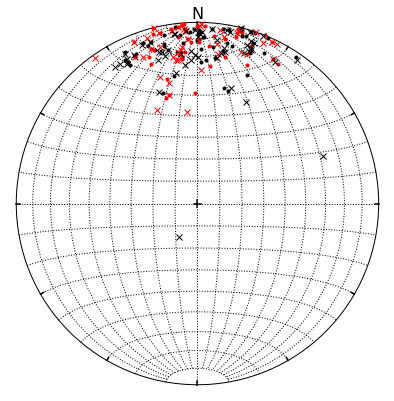

In [23]:
s = StereoNet(grid=True, legend=True)
settings['figsize'] = (7, 7)

for w in range (np.size(D_1)):
    if I_1[w] >= 0:
        symbol = '.'
        color = 'r'
    else:
        symbol = '.'
        color = 'k'

    if w == 0:
        s.line((Lin(float(D_1[w]), np.round(np.absolute(I_1[w])))), color=color, marker=symbol)
        #group.append((Lin(float(D[w]), np.round(np.absolute(I[w])))))
    else:
        s.line((Lin(float(D_1[w]), np.round(np.absolute(I_1[w])))), color=color, marker=symbol)
        #group.append((Lin(float(D[w]), np.round(np.absolute(I[w])))))
        
        
for k in range (np.size(D_FD_least)):
    if I_FD_least[k] >= 0:
        symbol = 'x'
        color = 'r'
    else:
        symbol = 'x'
        color = 'k'

    if k == 0:
        s.line((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))), color=color, marker=symbol)
        #group.append((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))))
    else:
        s.line((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))), color=color, marker=symbol)
        #group.append((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))))



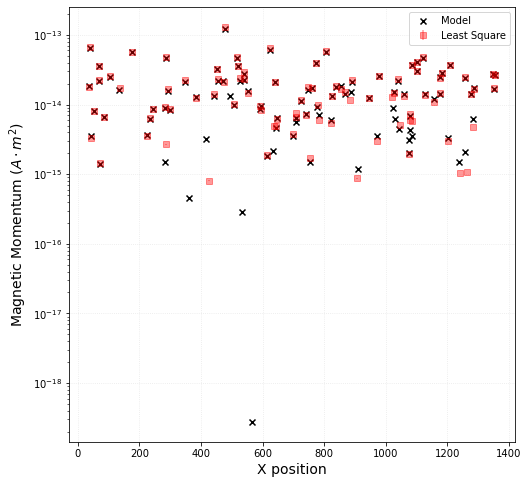

In [24]:
sources = np.copy(Xc_FD*m2microm)

real=(np.array(Q_1)*4/3*np.pi*np.array(R_1)**3)

plt.figure(figsize=(8,8))
plt.errorbar(sources, momentum_FD_least, sigma_m_FD_least, fmt='s', alpha=0.4, color='r', label='Least Square')


plt.scatter(np.array(Xc_1*m2microm), real, marker='x', color='k', label='Model')

plt.legend()
plt.grid(alpha=0.3, linestyle=':')

plt.xlabel('X position', fontsize=14);
plt.ylabel('Magnetic Momentum ($A \cdot m^2$)', fontsize=14);

plt.yscale('log')


## Forward Model and Errors

### Whole Area

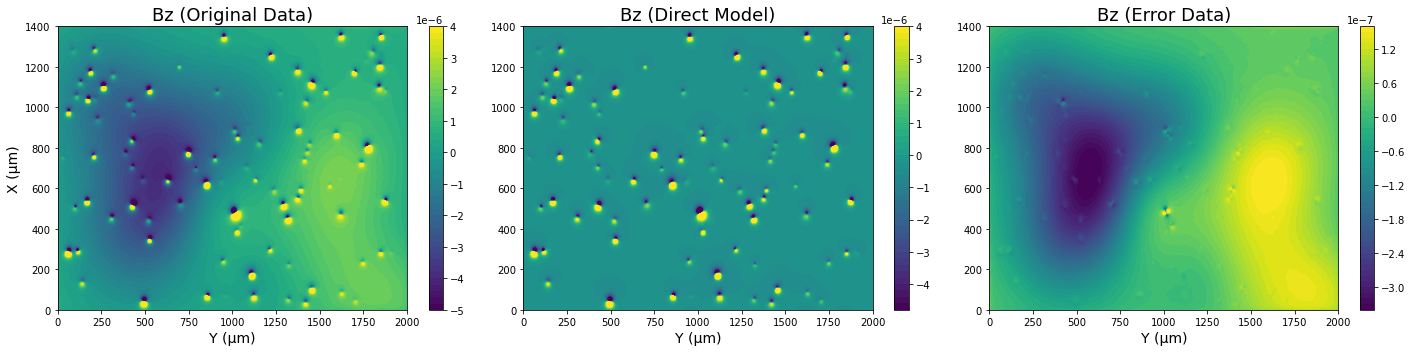

In [25]:
direct_model_FD_least = np.reshape(direct_model_FD_least, shape)

upward_direct_model_FD_least = upward_continuation(direct_model_FD_least, delta_z, wz)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

perc_min, perc_max = np.percentile(upward, (0.5,99.5))
original_data_view = skimage.exposure.rescale_intensity(upward, in_range=(perc_min, perc_max))
ax4_plot = ax1.contourf(x_plot, y_plot, upward, levels=50, cmap='viridis')
ax1_plot = ax1.contourf(x_plot, y_plot, original_data_view, levels=50, cmap='viridis')

plt.colorbar(ax4_plot, ax=ax1)
ax1.set_title('Bz (Original Data)', fontsize=18)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)


perc_min, perc_max = np.percentile(upward_direct_model_FD_least, (0.5,99.5))
direct_model_view = skimage.exposure.rescale_intensity(upward_direct_model_FD_least, in_range=(perc_min, perc_max))
ax5_plot = ax2.contourf(x_plot, y_plot, upward_direct_model_FD_least, levels=50, cmap='viridis')
ax2_plot = ax2.contourf(x_plot, y_plot, direct_model_view, levels=50, cmap='viridis')
plt.colorbar(ax5_plot, ax=ax2)
ax2.set_title('Bz (Forward Model)', fontsize=18)
ax2.set_xlabel('Y (µm)', fontsize=14)

error = upward - upward_direct_model_FD_least
perc_min, perc_max = np.percentile(error, (0.5,99.5))
error_data_view = skimage.exposure.rescale_intensity(error, in_range=(perc_min, perc_max))
ax6_plot = ax3.contourf(x_plot, y_plot, error, levels=50, cmap='viridis')
ax3_plot = ax3.contourf(x_plot, y_plot, error_data_view, levels=50, cmap='viridis')
plt.colorbar(ax6_plot, ax=ax3)
ax3.set_title('Bz (Error Data)', fontsize=18)
ax3.set_xlabel('Y (µm)', fontsize=14)



plt.tight_layout()

R2:  0.9989205392317692


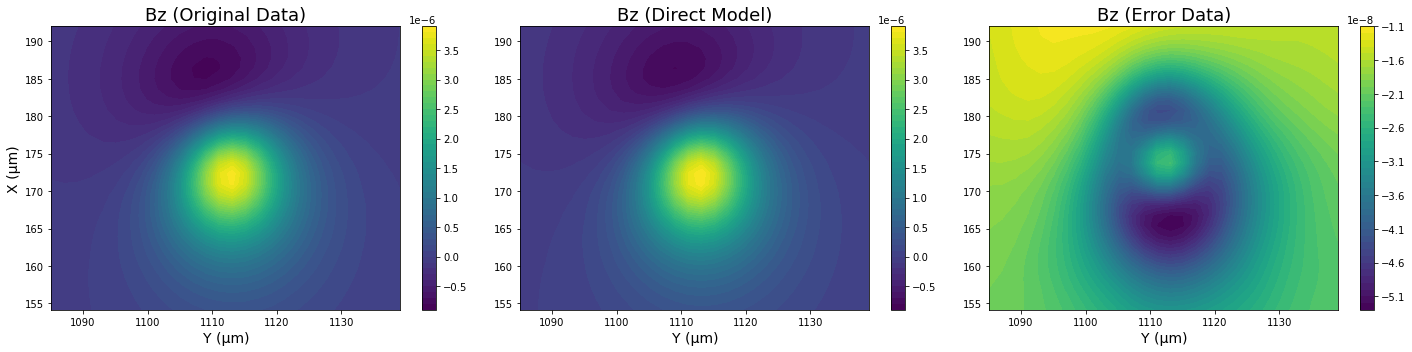

R2:  0.9916090123619324


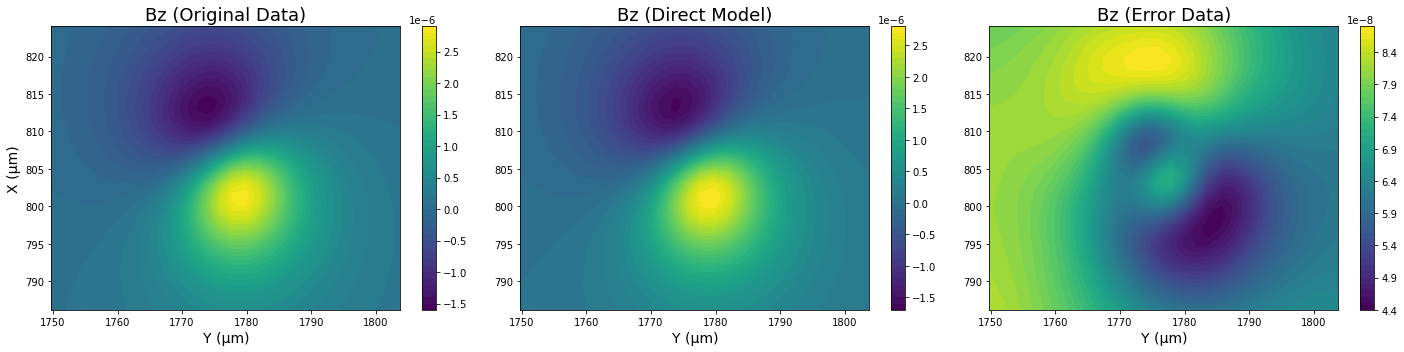

R2:  0.995321833872158


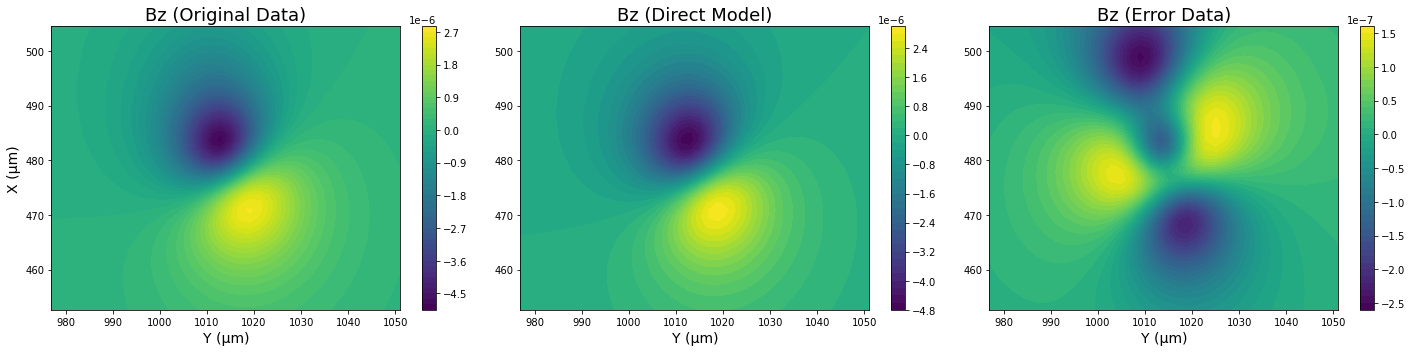

R2:  0.9980883182583495


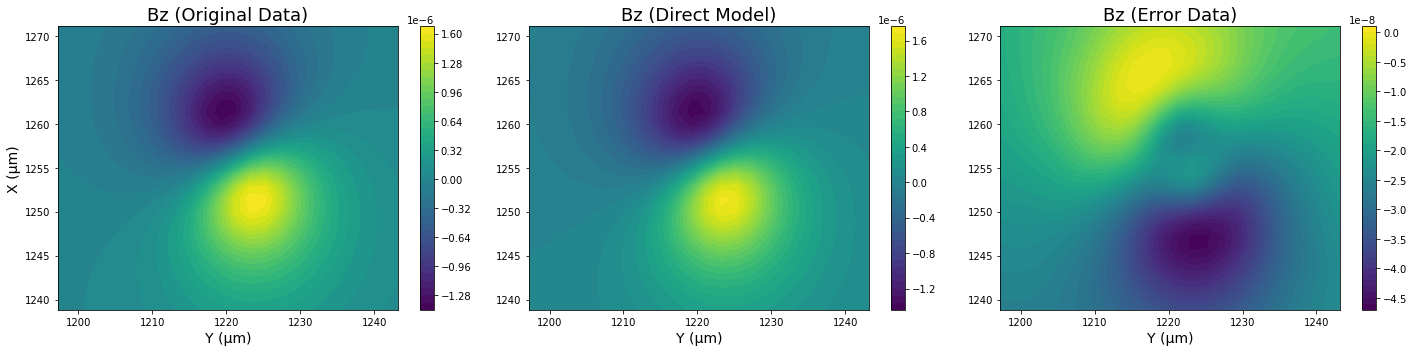

R2:  0.9903595114869492


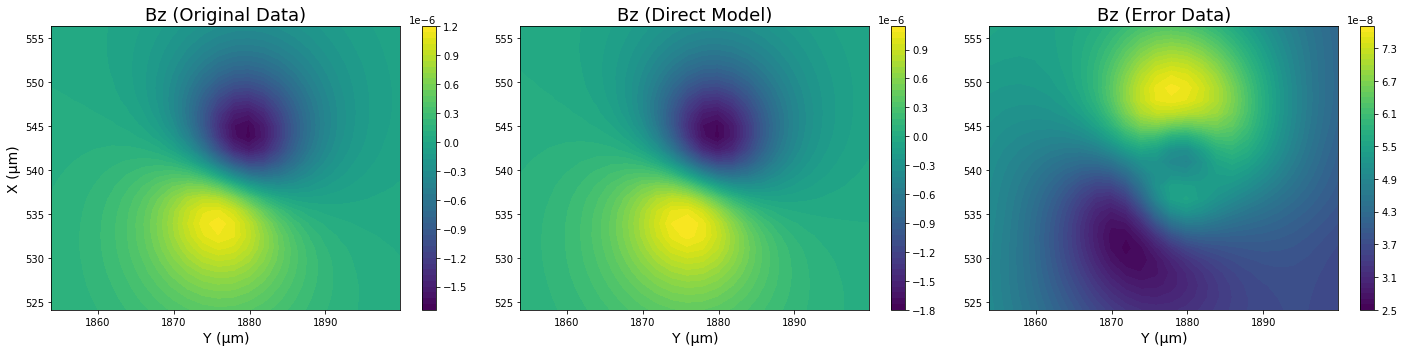

R2:  0.9620817841453753


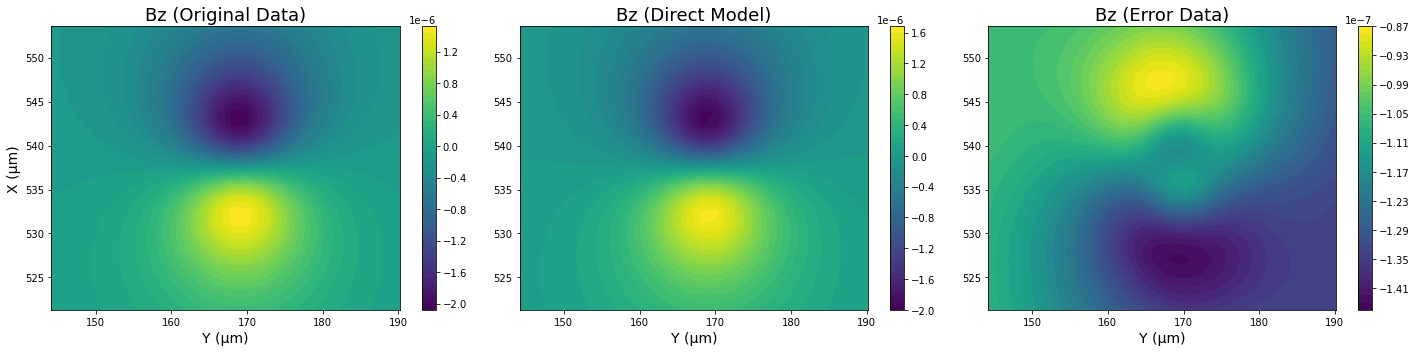

R2:  0.9964300621858827


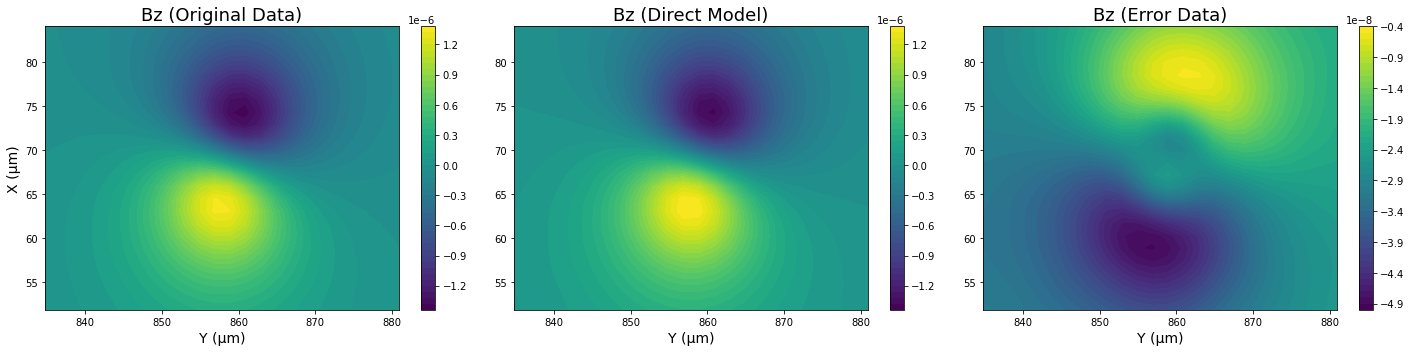

R2:  0.910087832379474


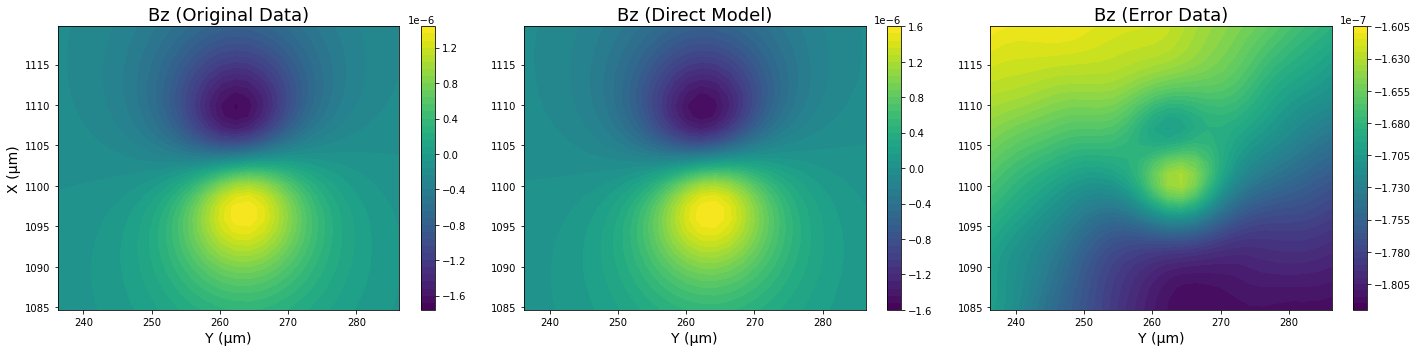

R2:  0.9279957070208275


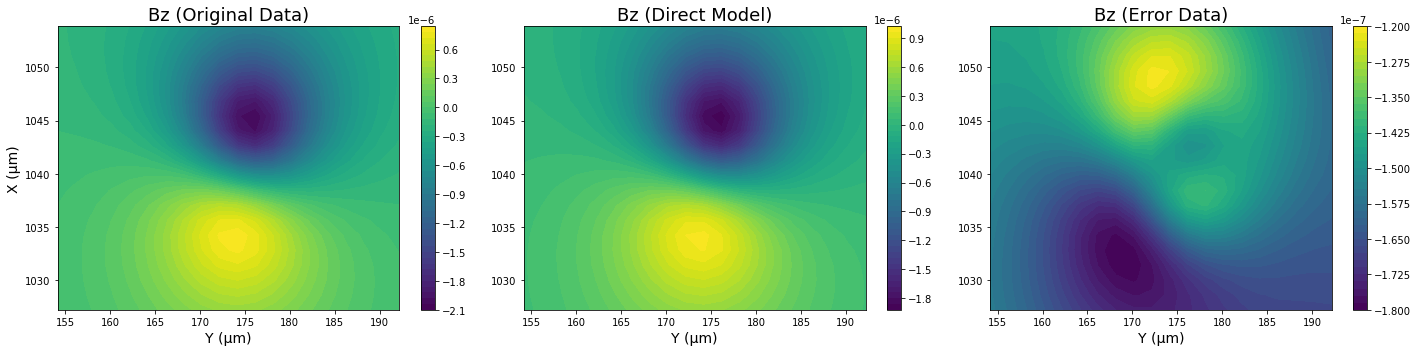

R2:  0.9987894355823231


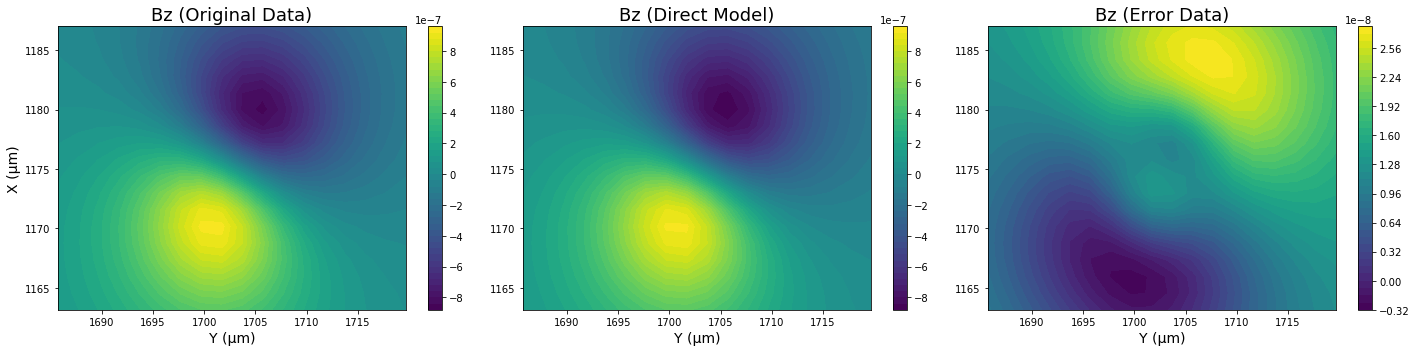

R2:  0.6846313618655764


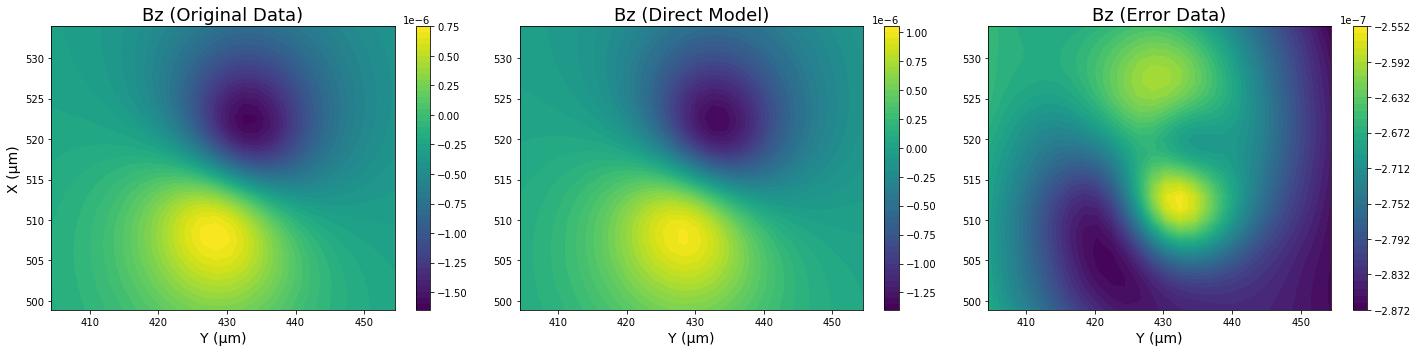

R2:  0.9224009499779071


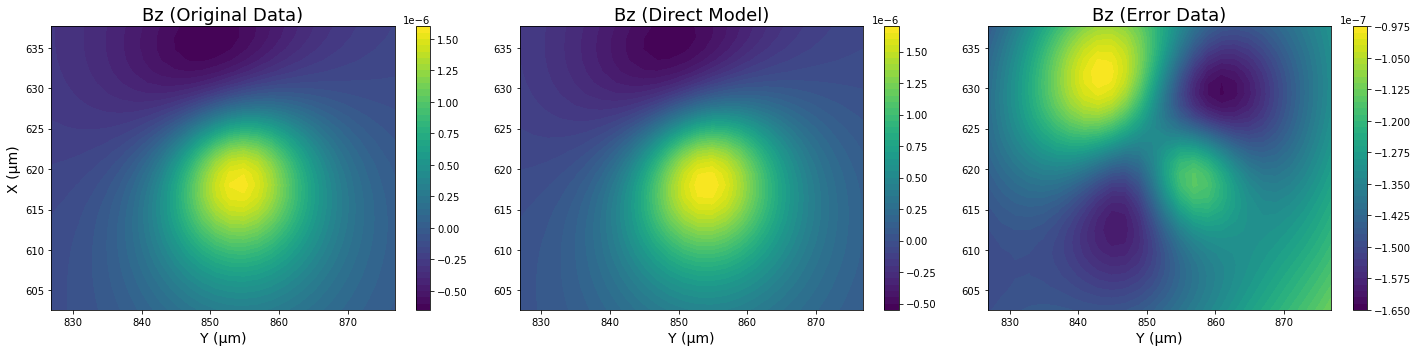

R2:  0.9860309487479584


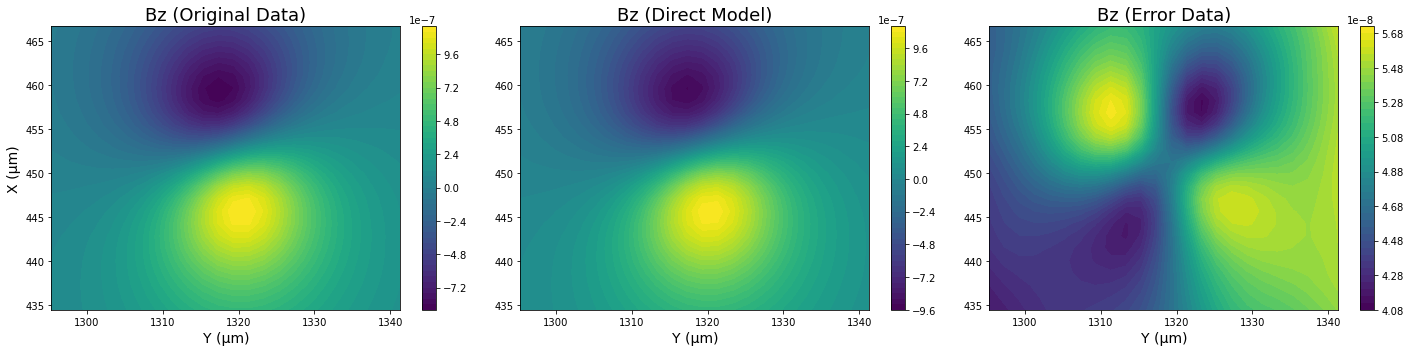

R2:  0.9997963130183183


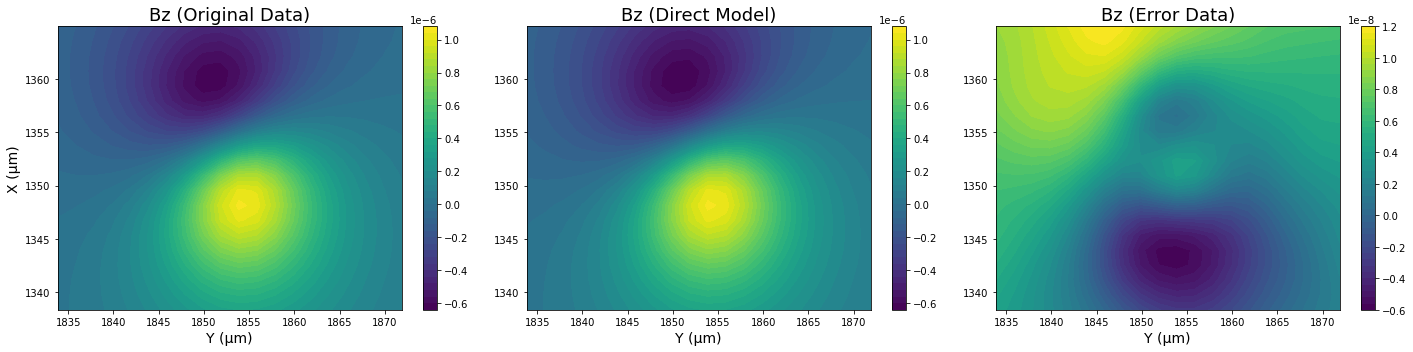

R2:  0.9761879697726978


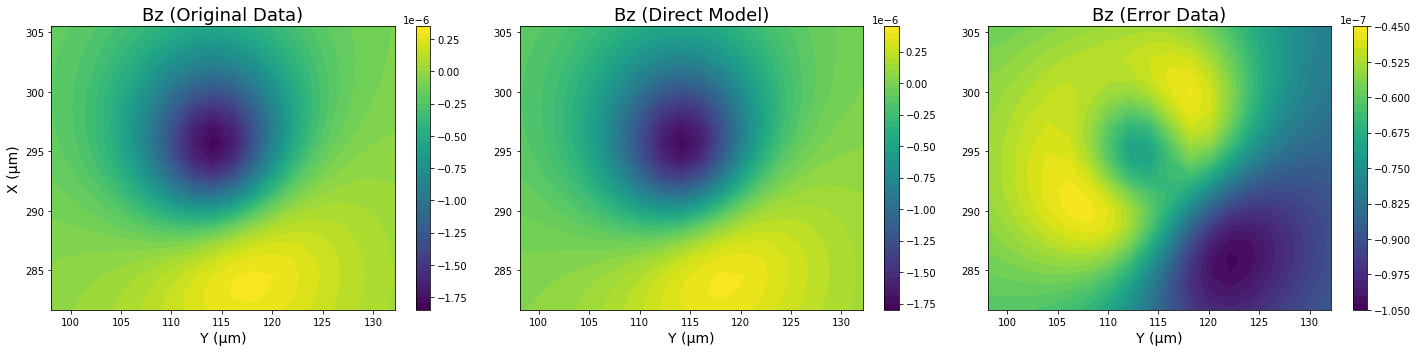

R2:  0.8155407227883235


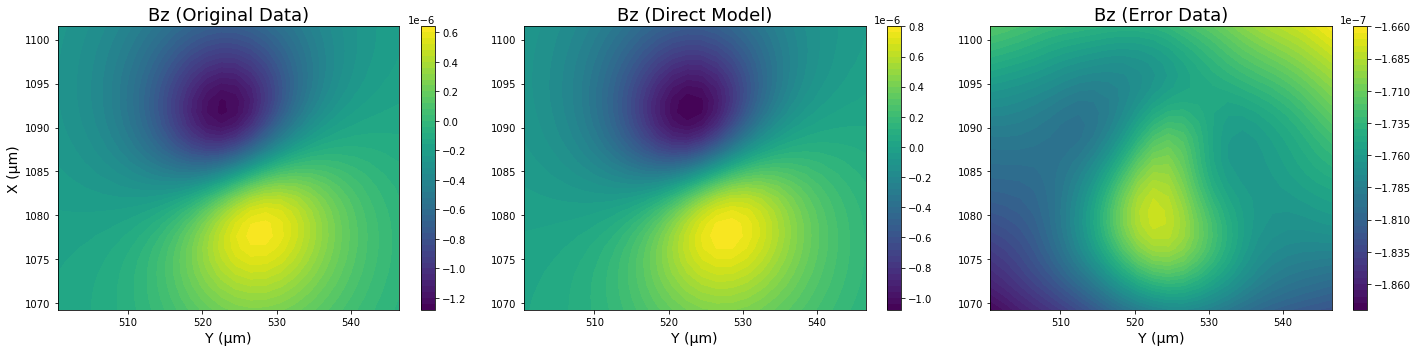

R2:  0.9976399186680314


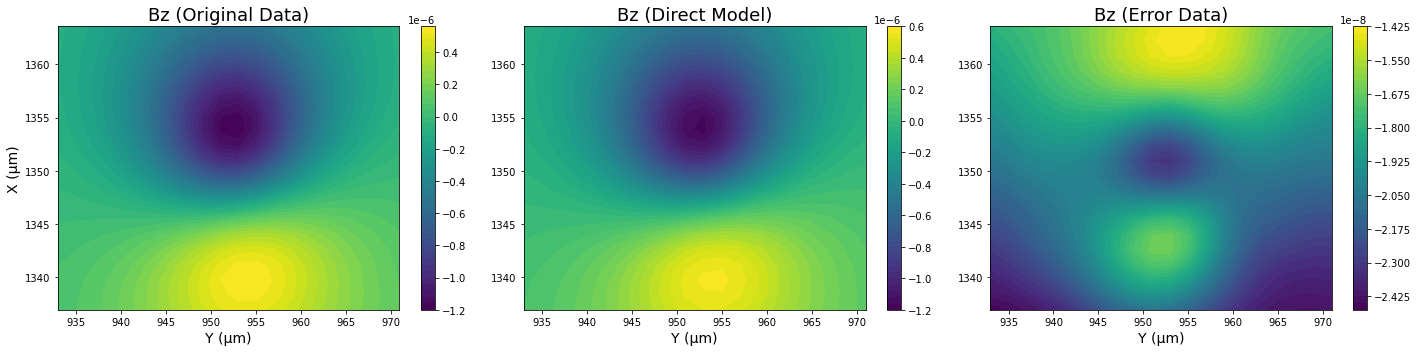

R2:  0.9821250102187933


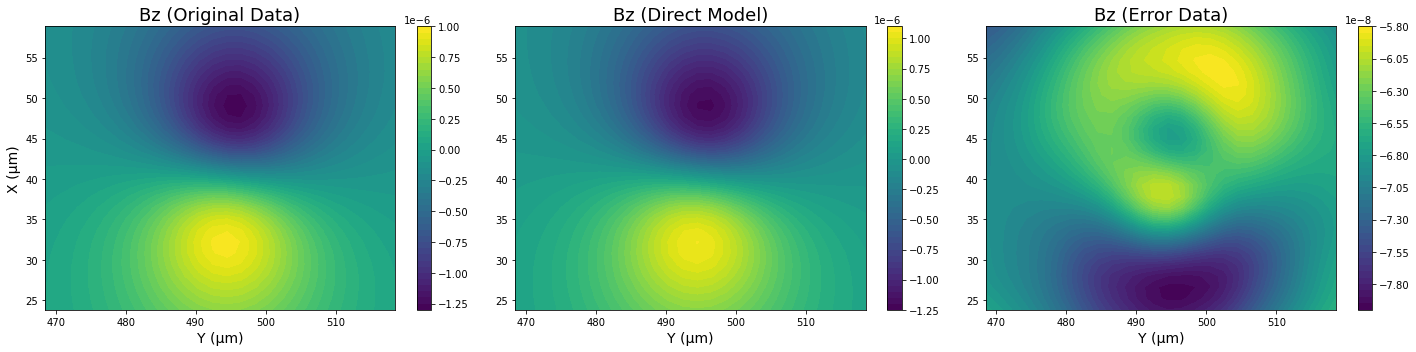

R2:  0.9993688173731082


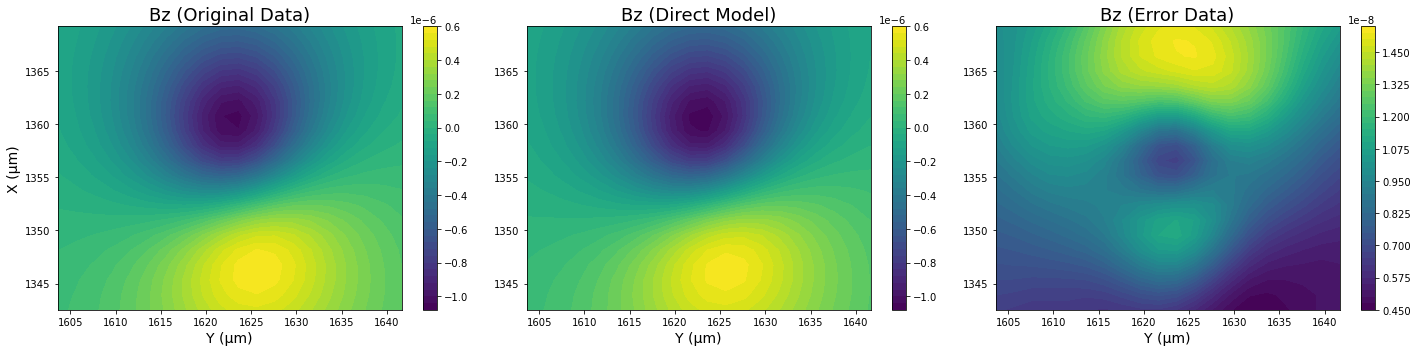

R2:  0.9998721685442219


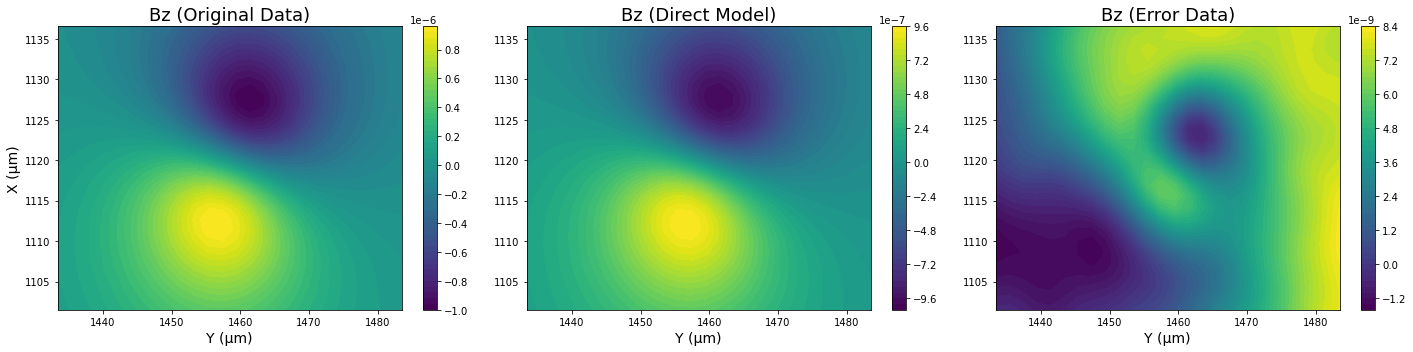

R2:  0.9879136015099714


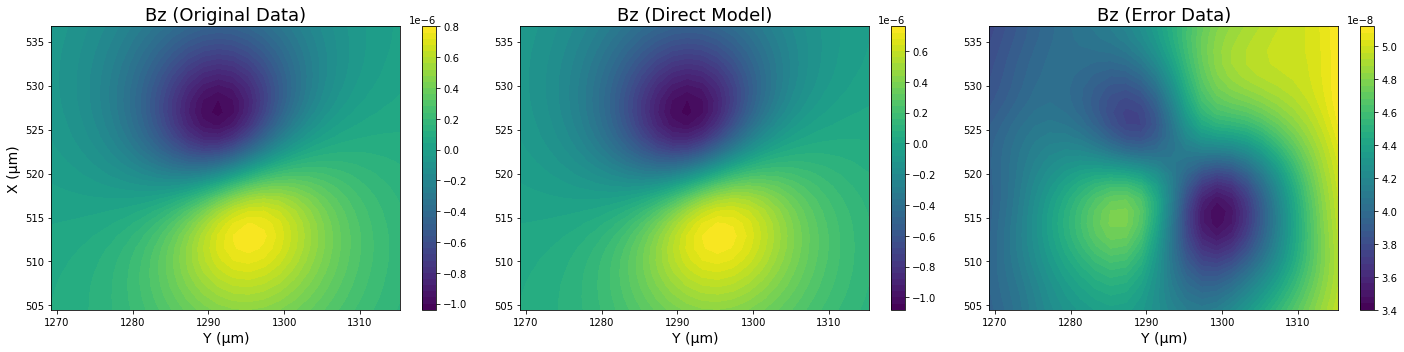

R2:  0.9920663521689005


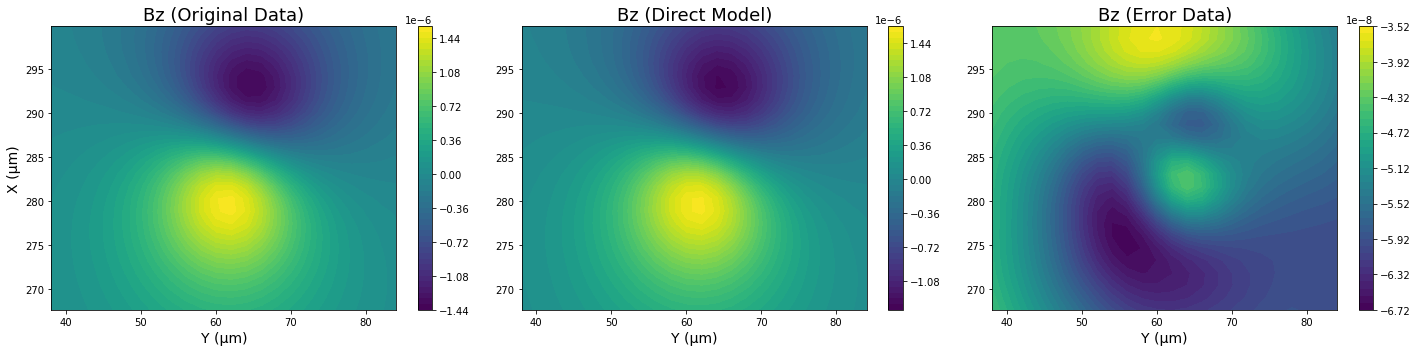

R2:  0.444020445233697


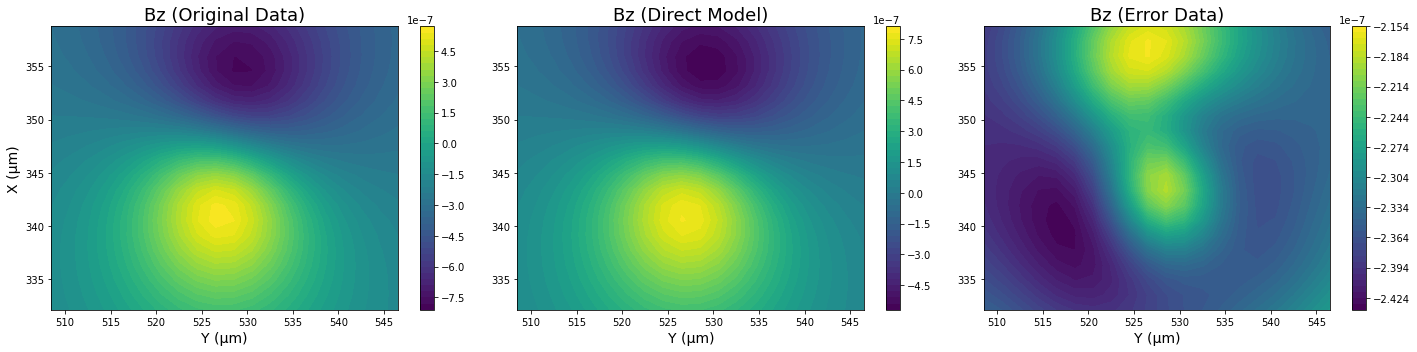

R2:  0.3720914438547249


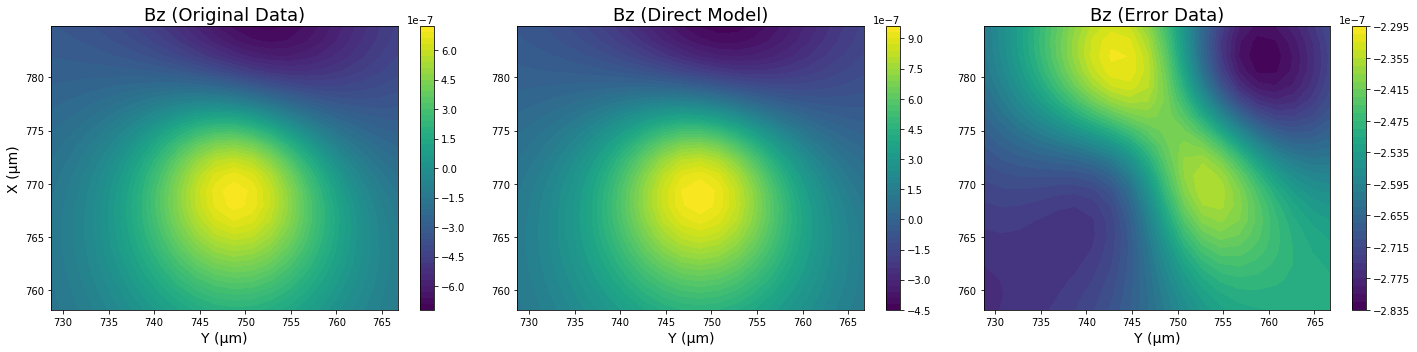

R2:  0.8198463503890359


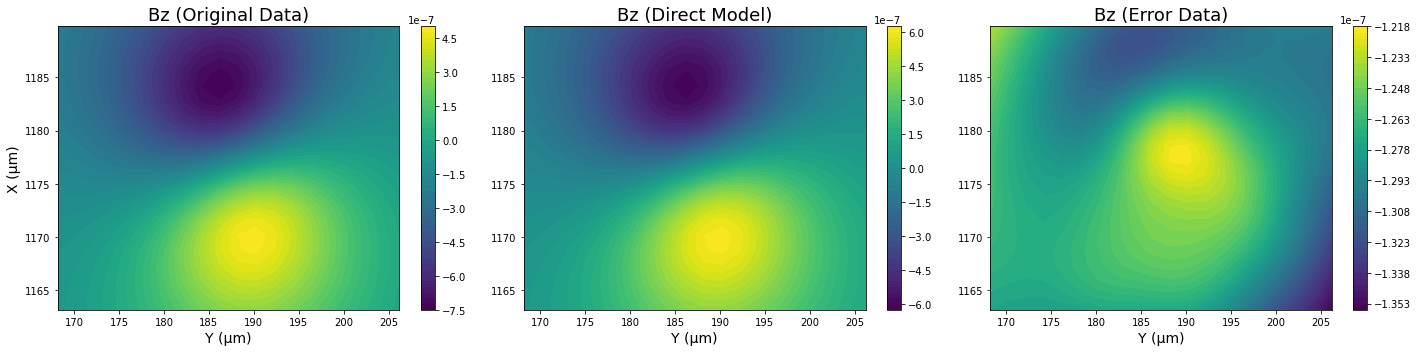

R2:  0.8192498087405407


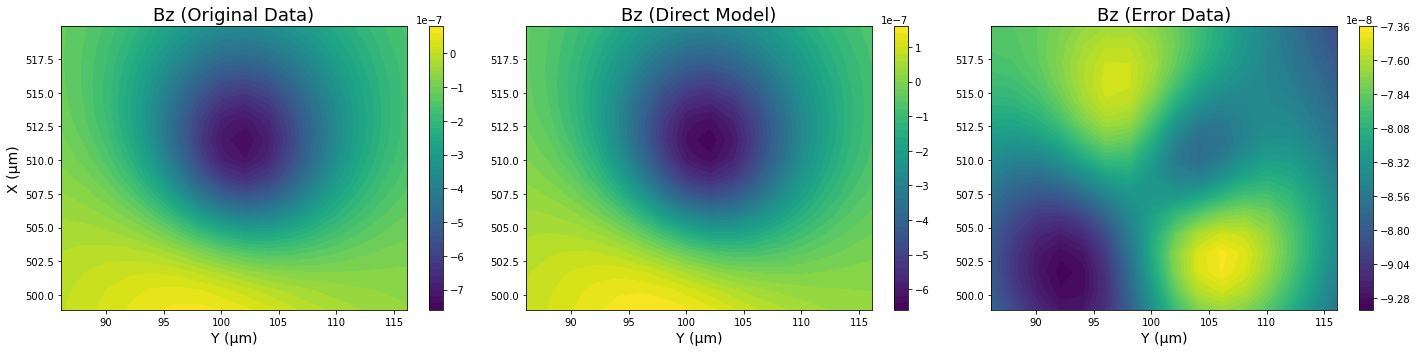

R2:  0.9669951625153406


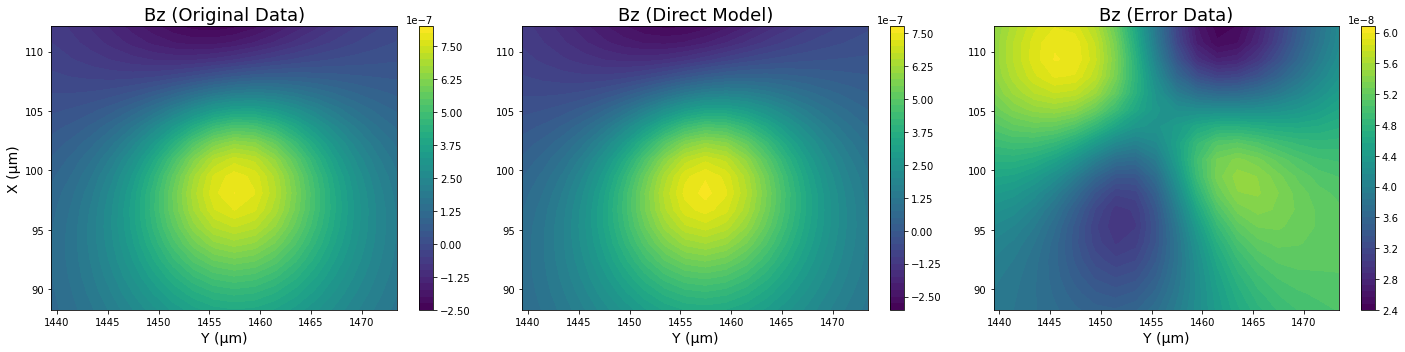

R2:  0.9985153529900851


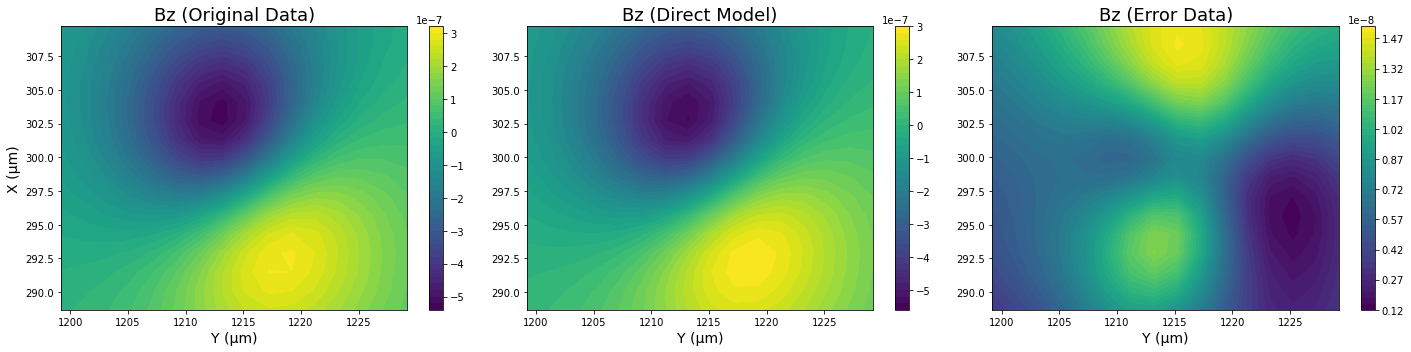

R2:  -0.33052966666274264


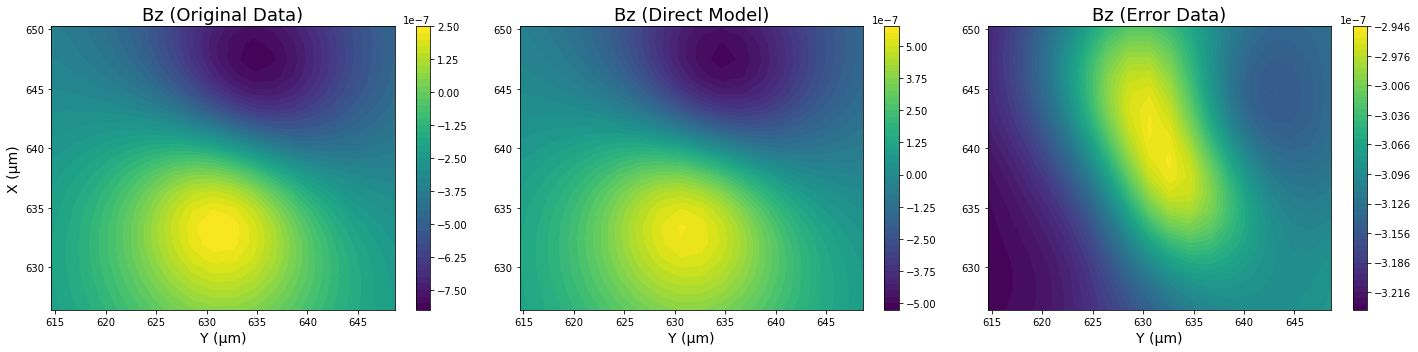

R2:  0.868451393567471


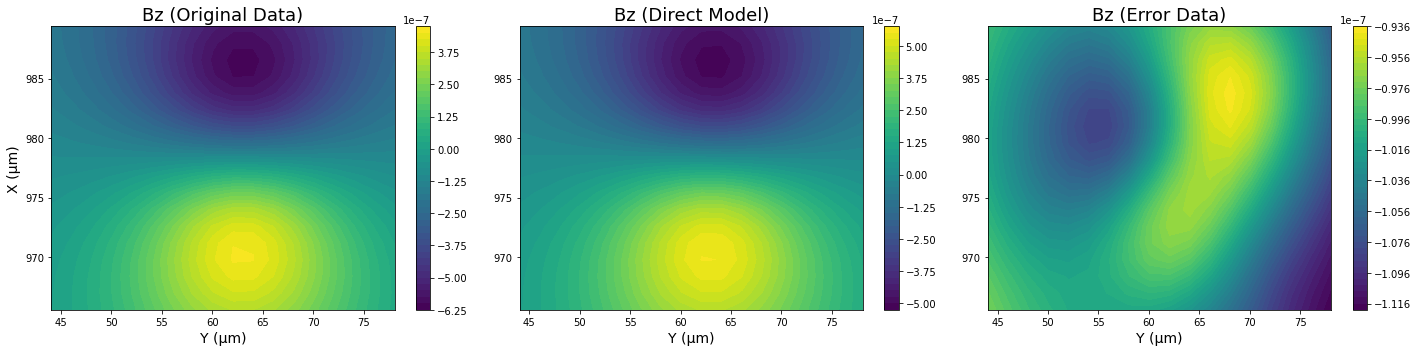

R2:  0.9938713390173602


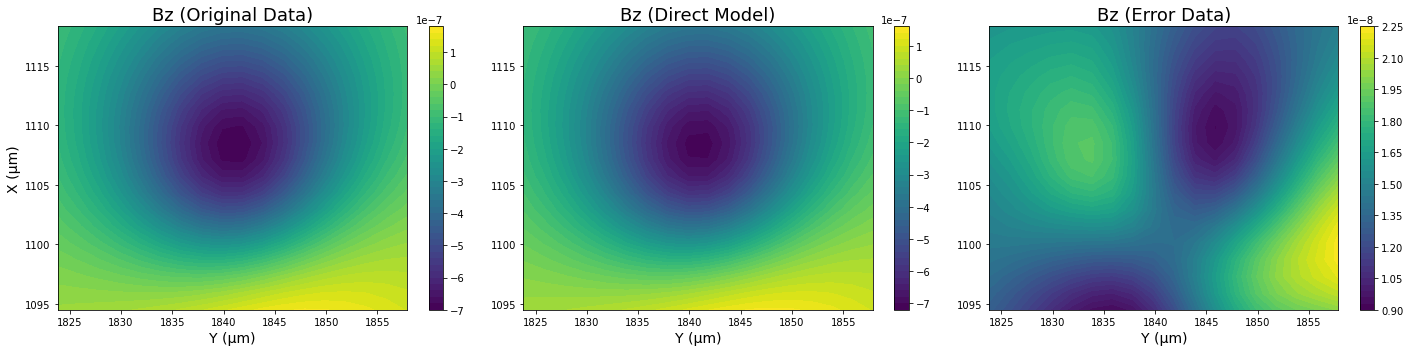

R2:  -0.16401965935799567


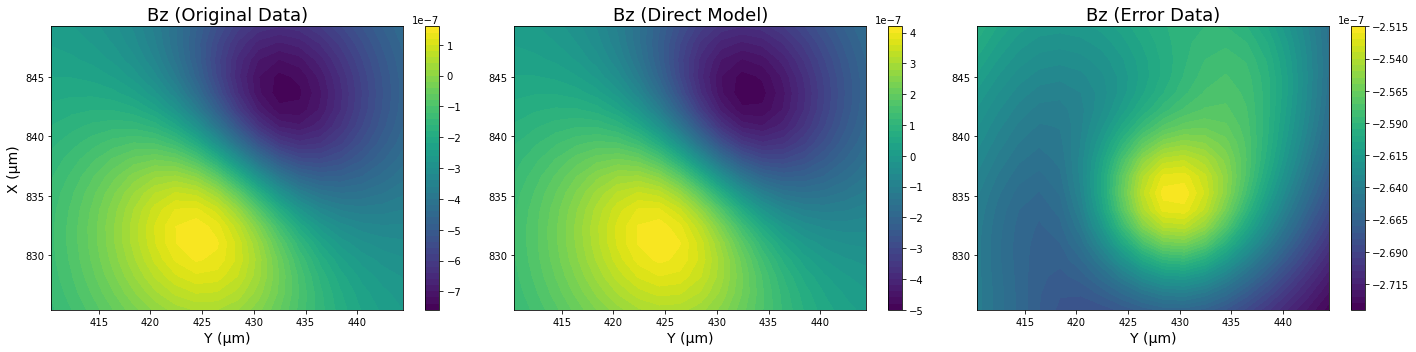

R2:  0.9989944455769282


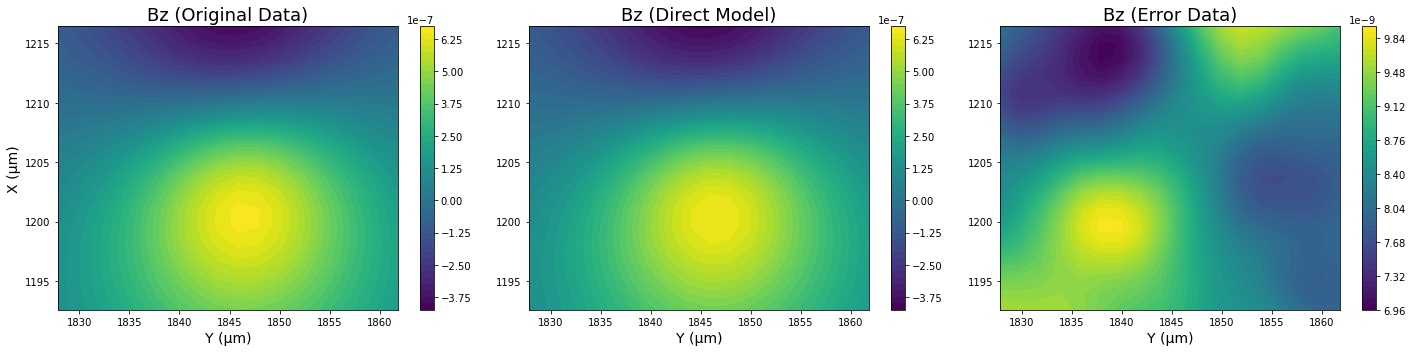

R2:  0.5219623134462971


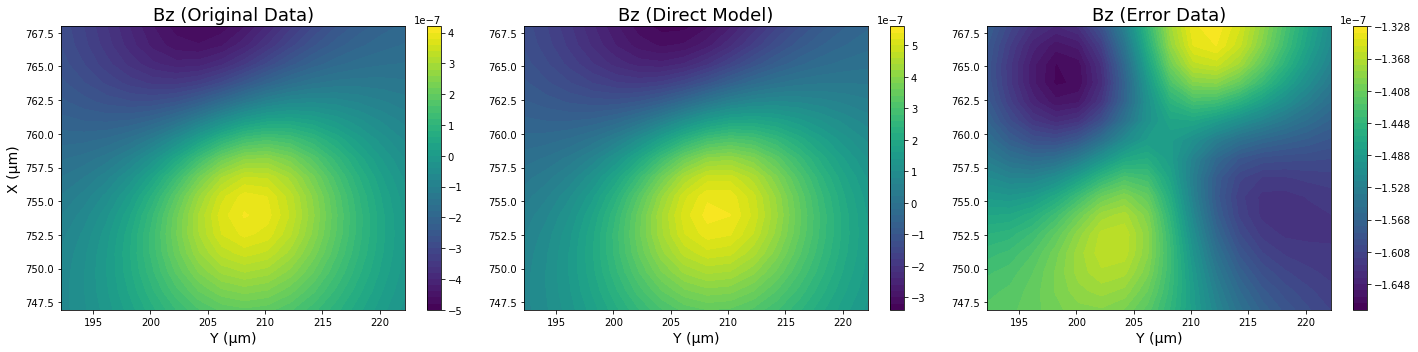

R2:  0.8715408832790159


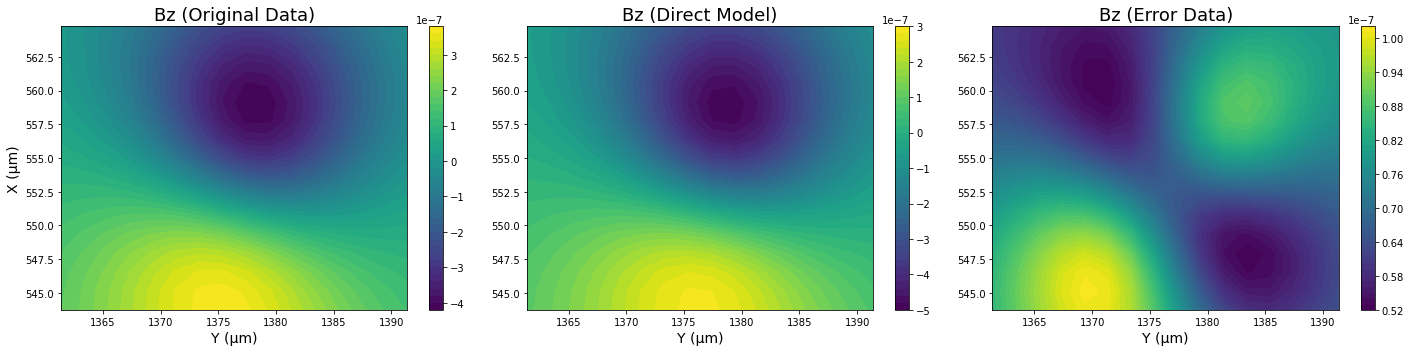

R2:  0.797005678325852


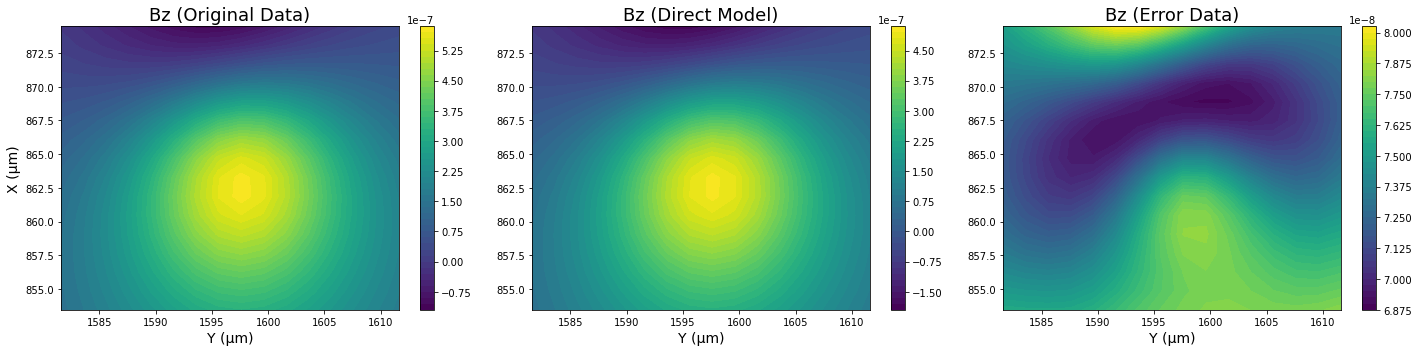

R2:  0.8137606683911902


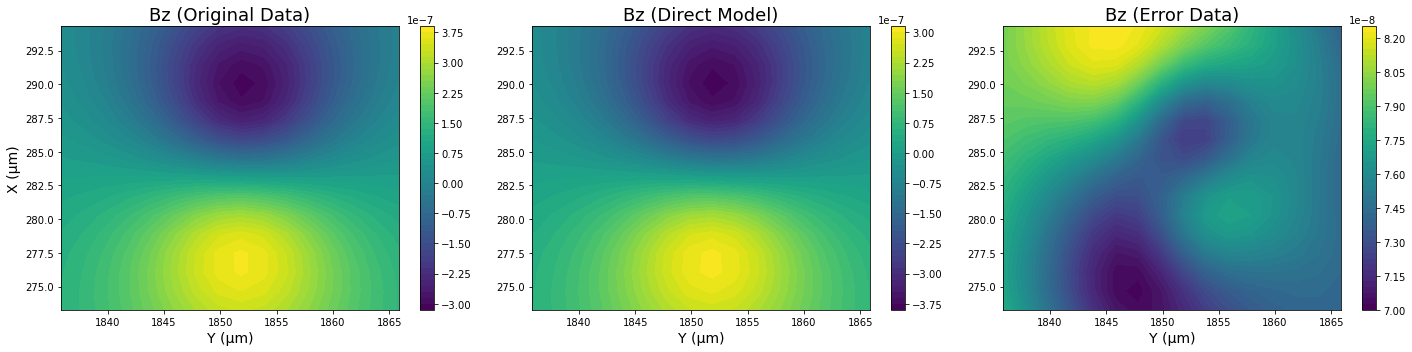

R2:  0.9913277582379733


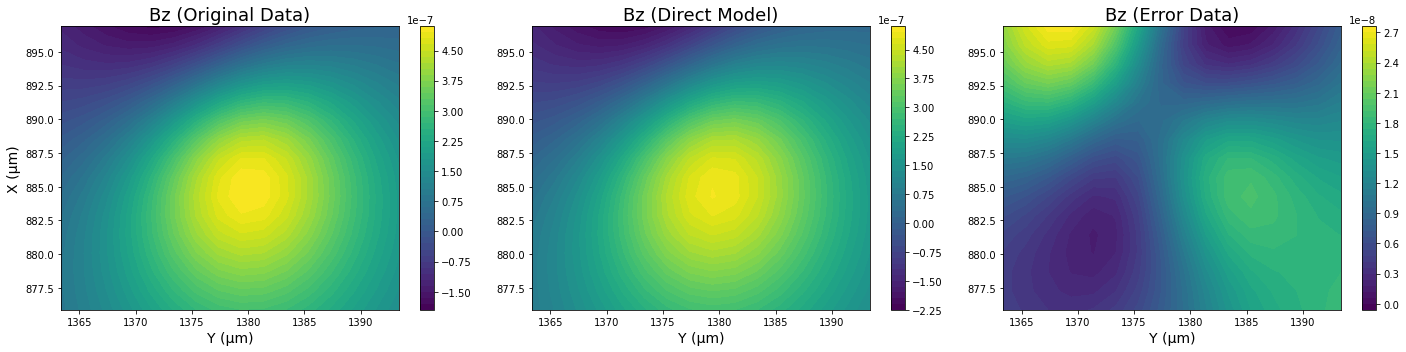

R2:  0.9875428867673243


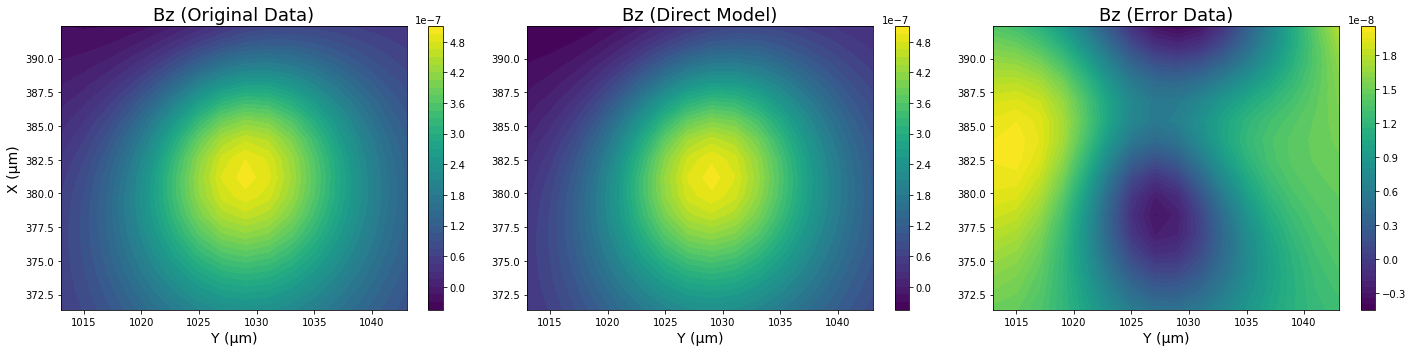

R2:  0.7994278995736241


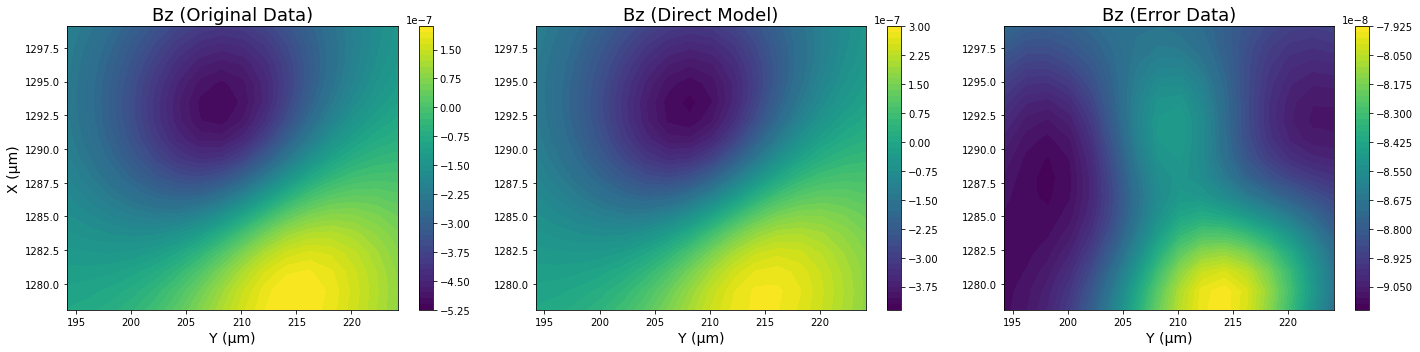

R2:  0.9914171607944127


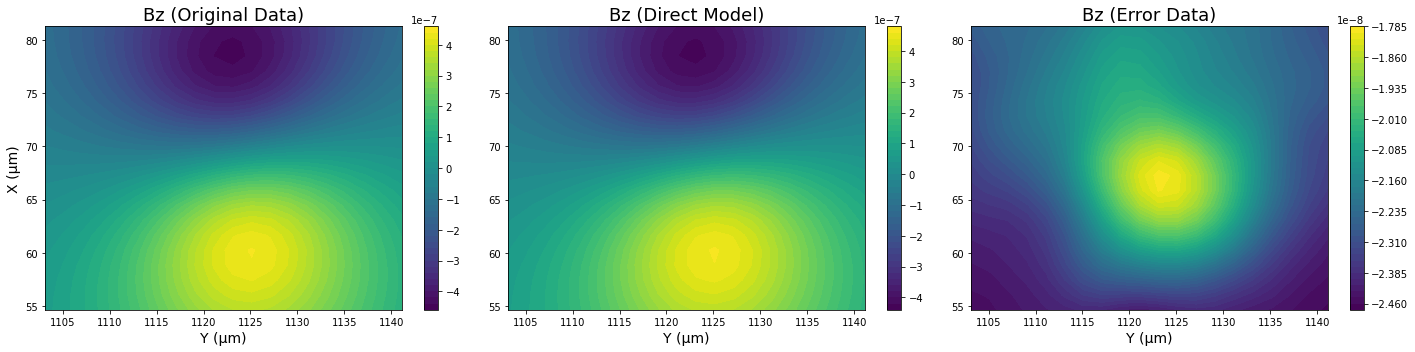

R2:  0.9984806541324636


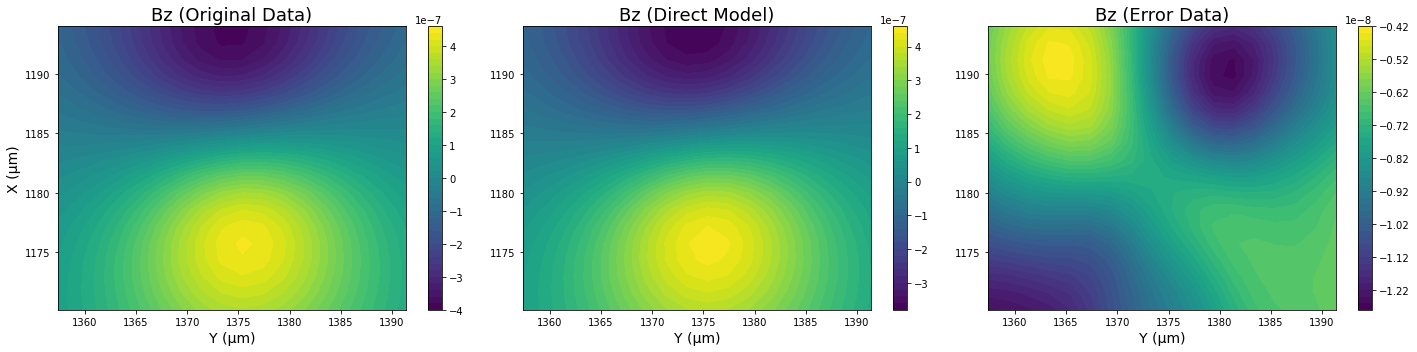

R2:  0.5357099607570813


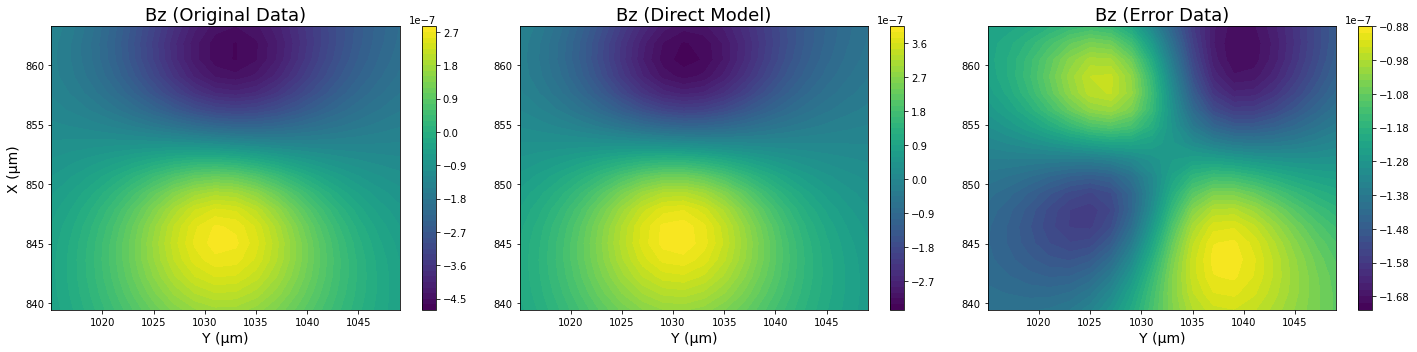

R2:  -3.1020407955567384


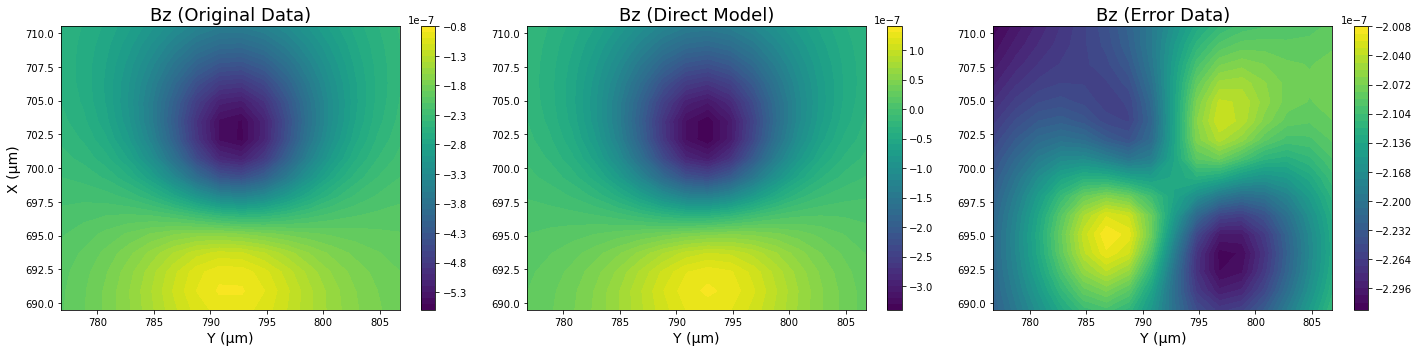

R2:  0.2871159871964962


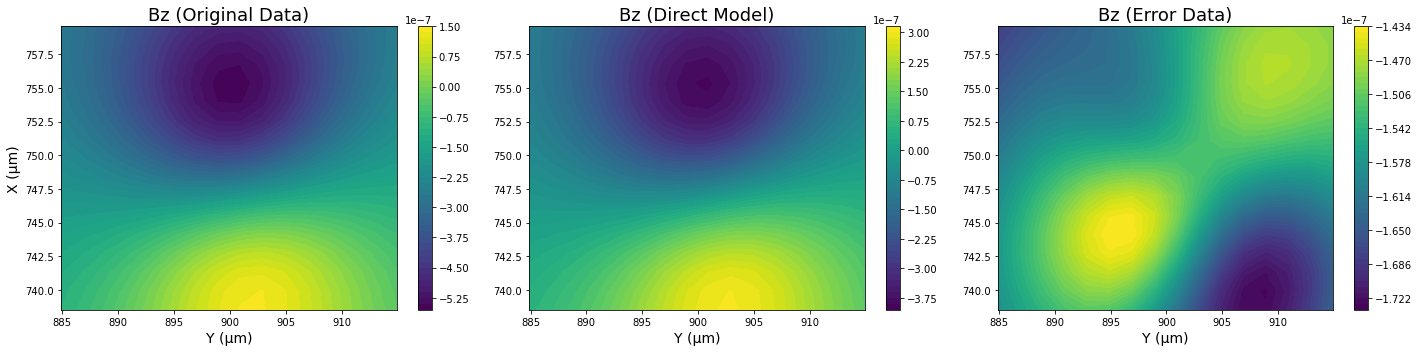

R2:  0.9827722918437304


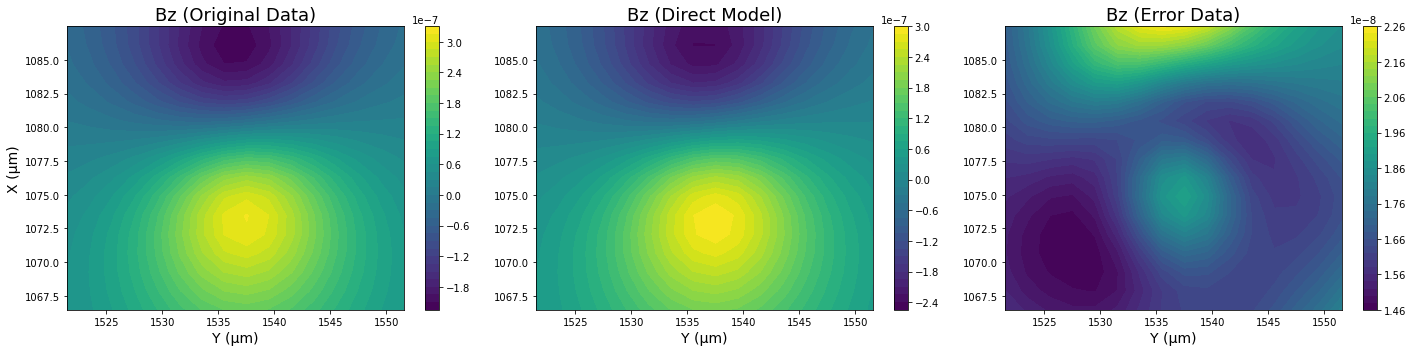

R2:  0.987414051438822


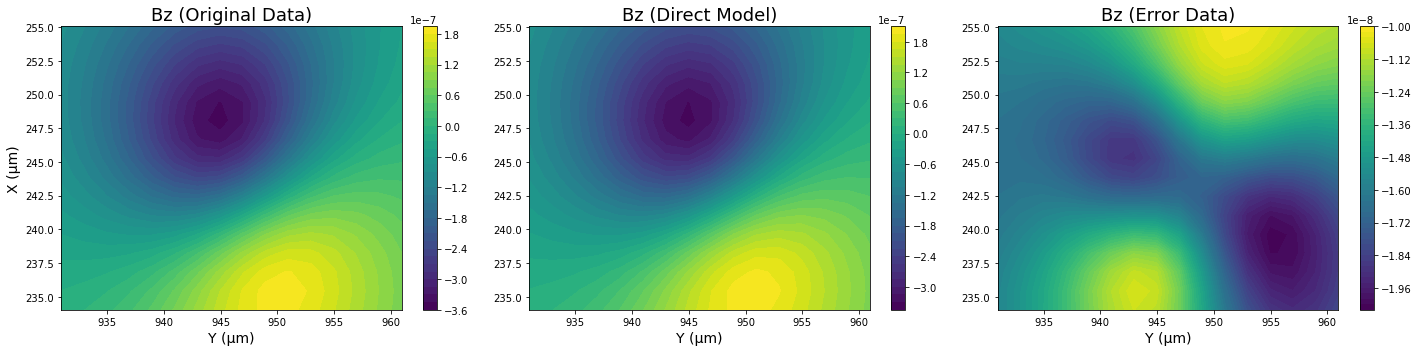

R2:  0.9696924650942101


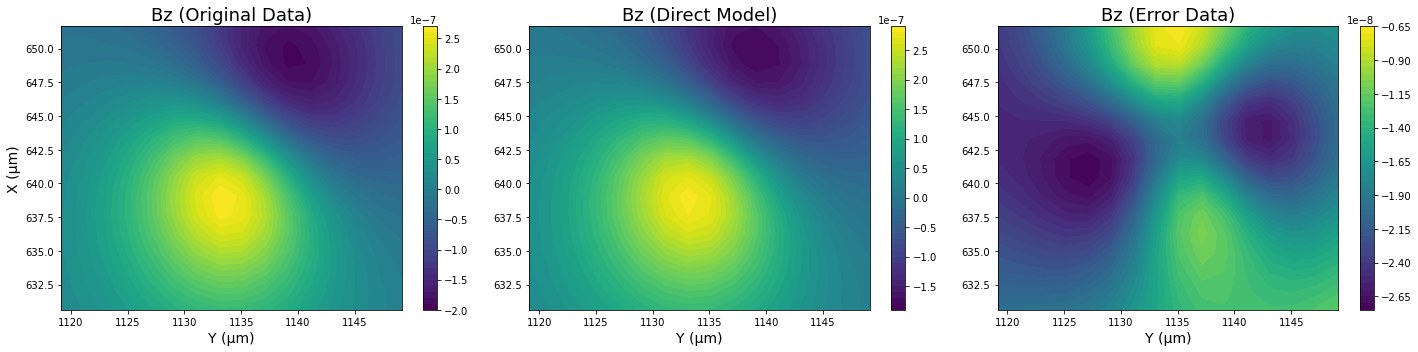

R2:  0.9703525540258323


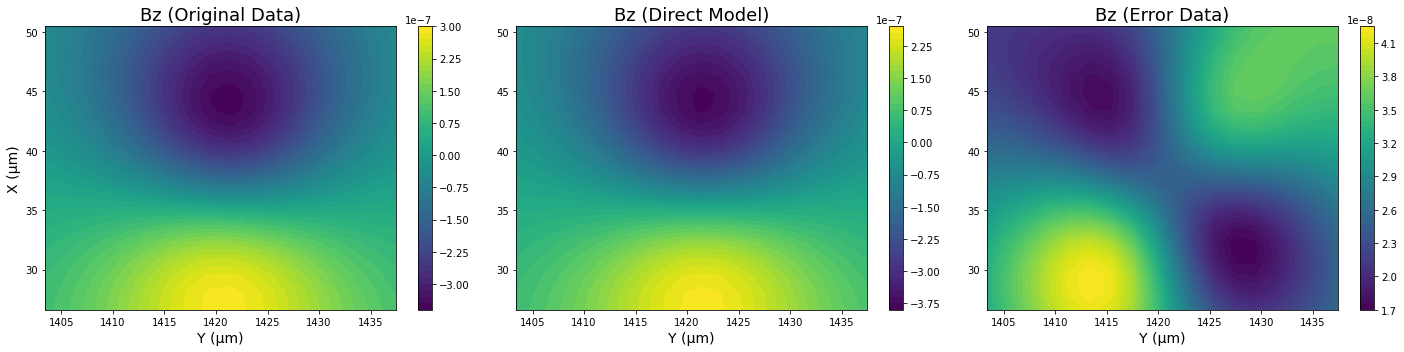

R2:  0.6435832069530967


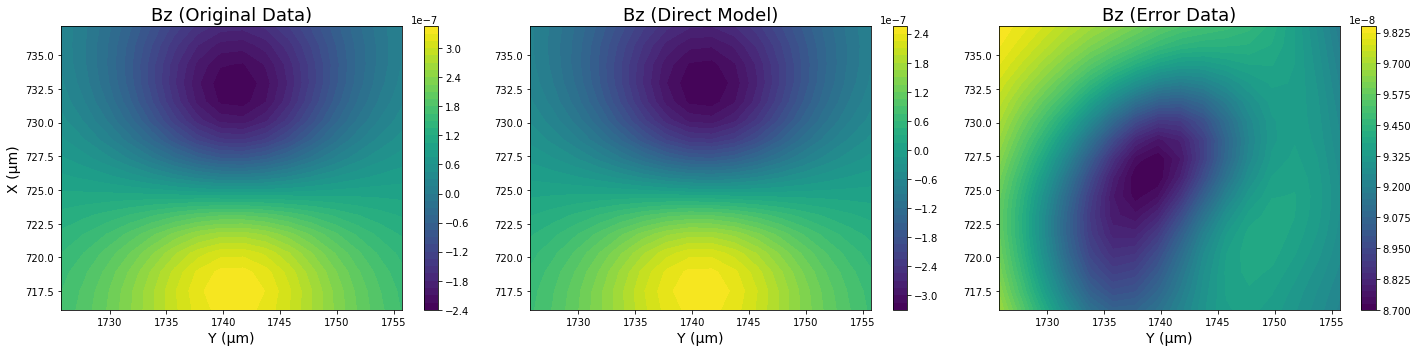

R2:  -0.20076744710340577


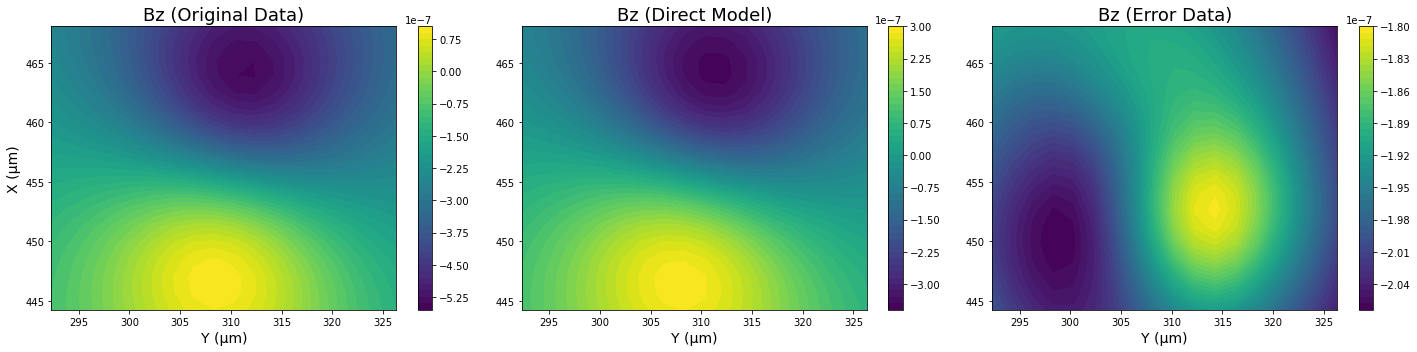

R2:  -5.139669341931293


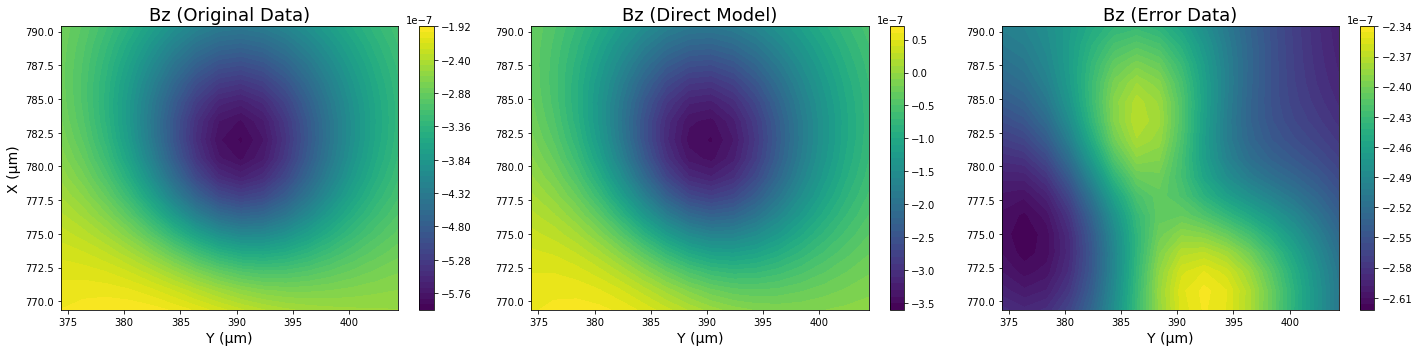

R2:  -2.5955575558102506


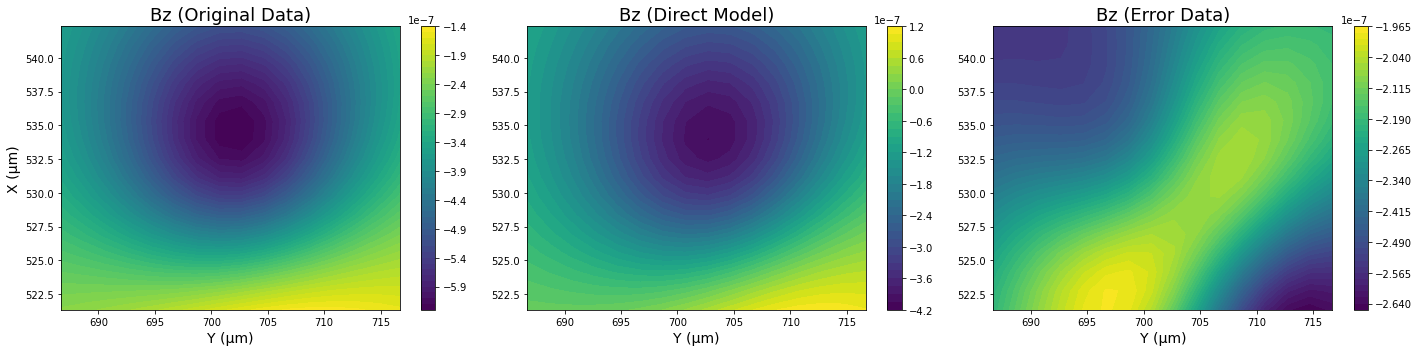

R2:  0.4195200625161395


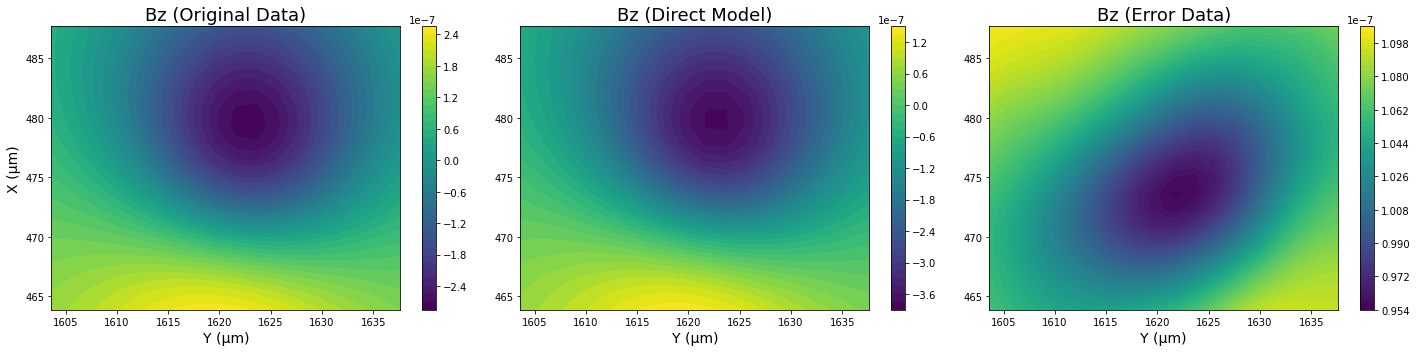

R2:  0.6075982265818918


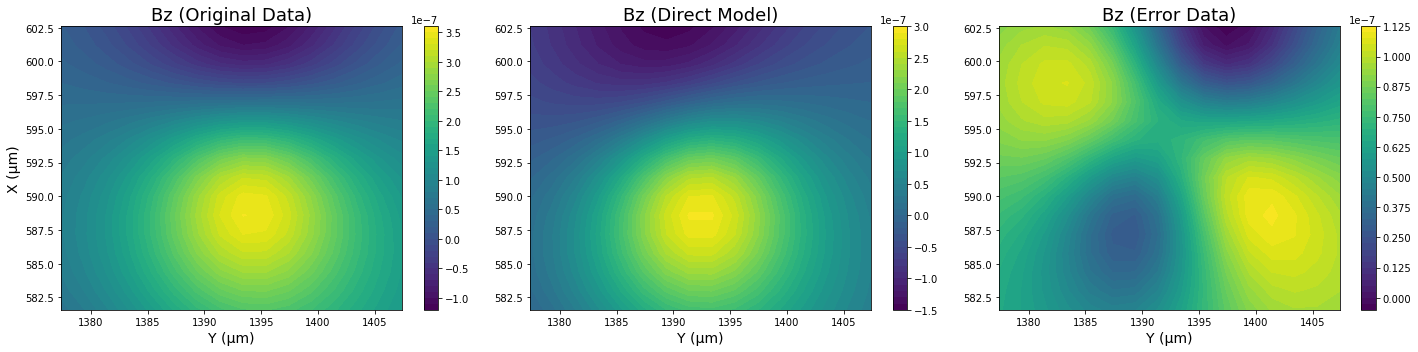

R2:  0.048313038222209226


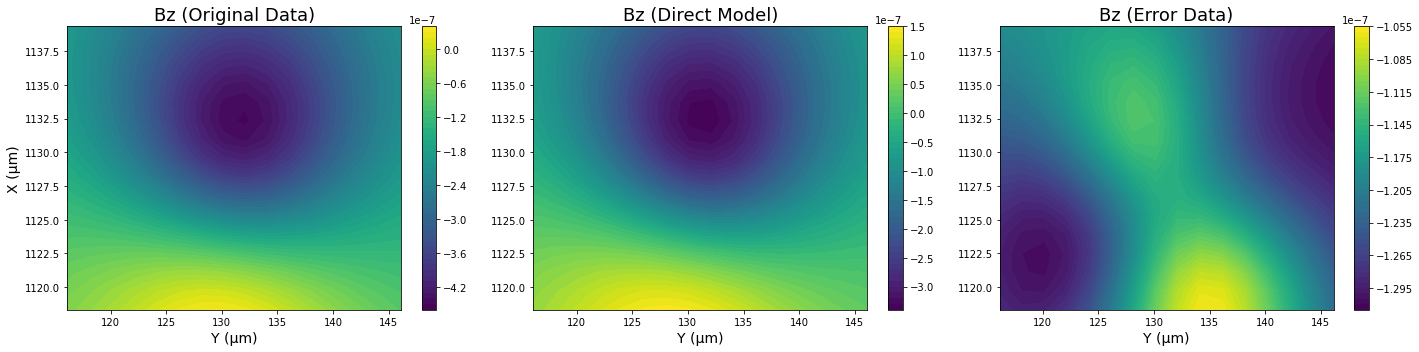

R2:  -0.7200342913393263


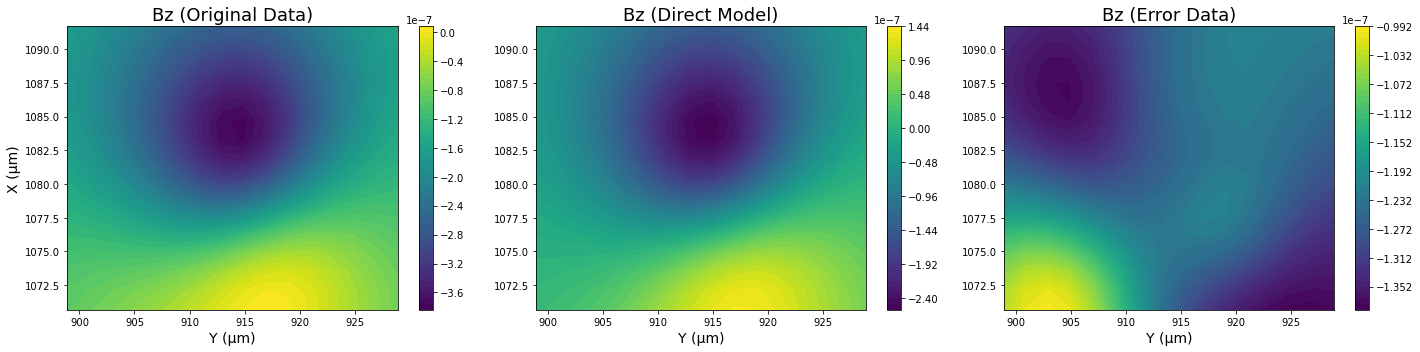

R2:  0.9982807398073146


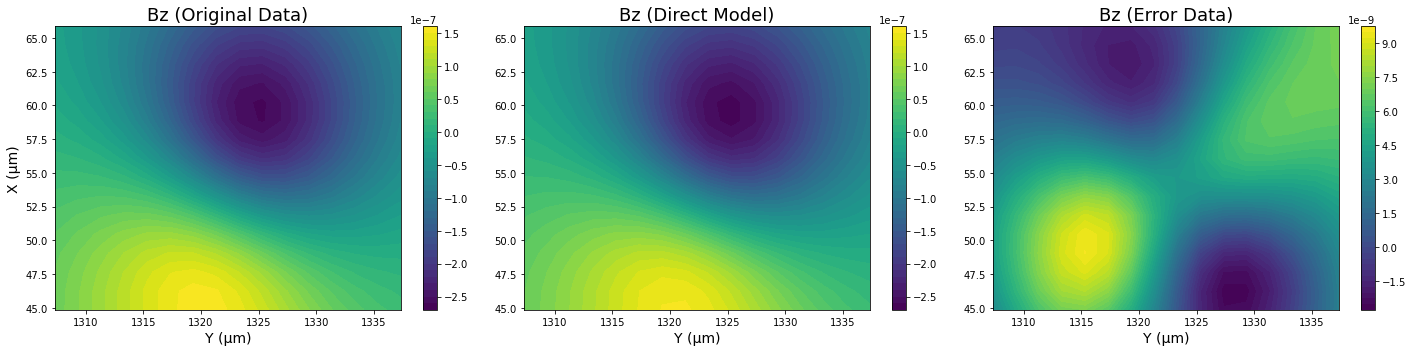

R2:  -5.738855803438953


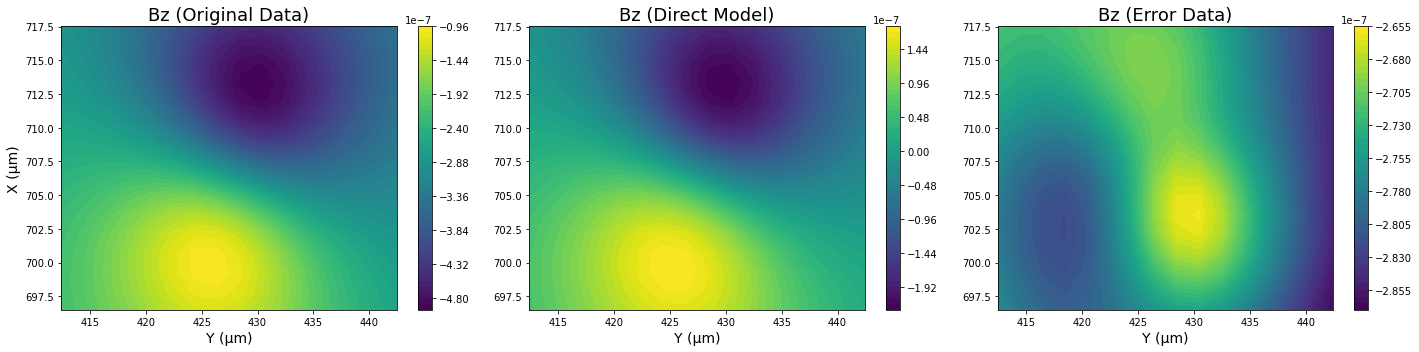

R2:  -1.2059687414220344


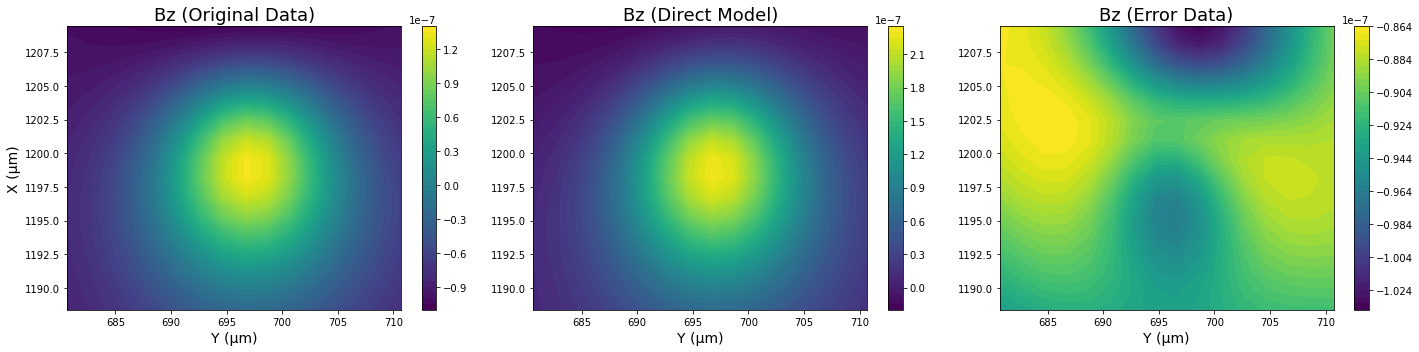

R2:  0.9985113334789605


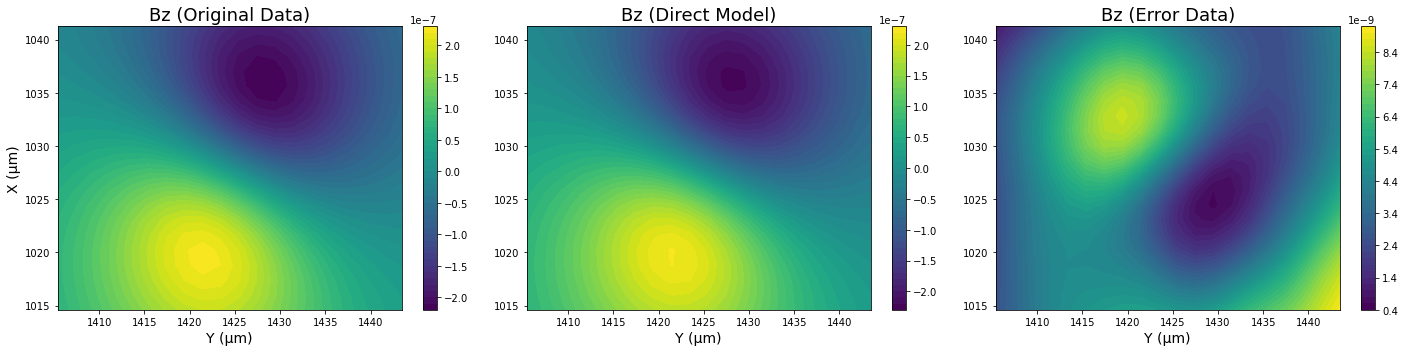

R2:  -7.475819537328832


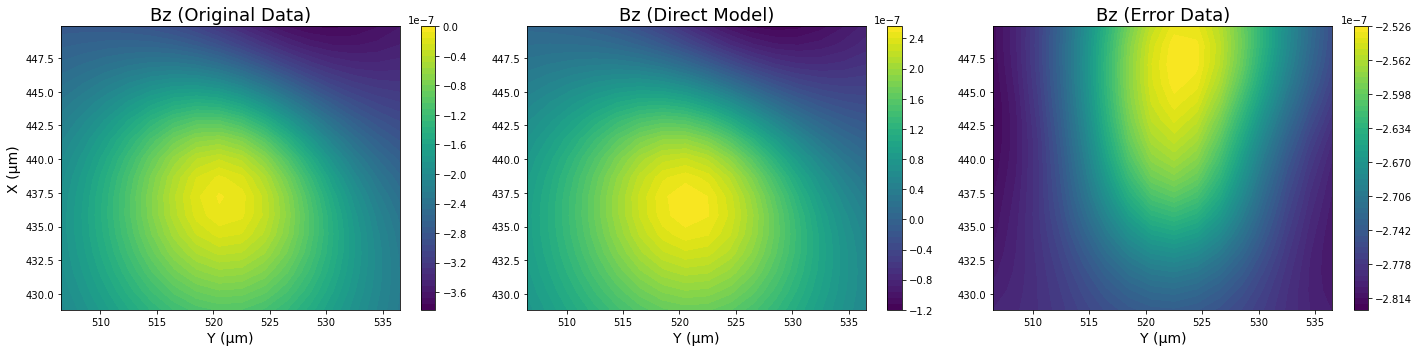

R2:  0.5009679668115166


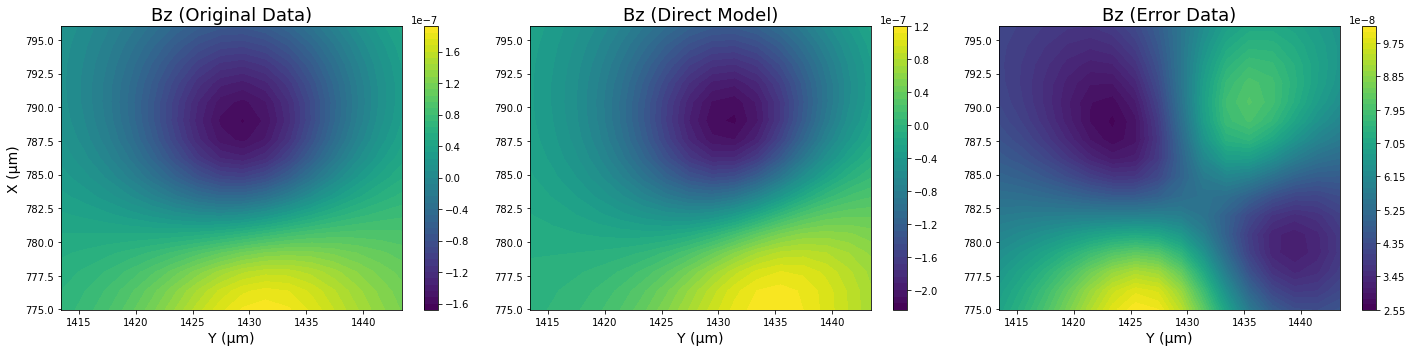

R2:  0.751082863314577


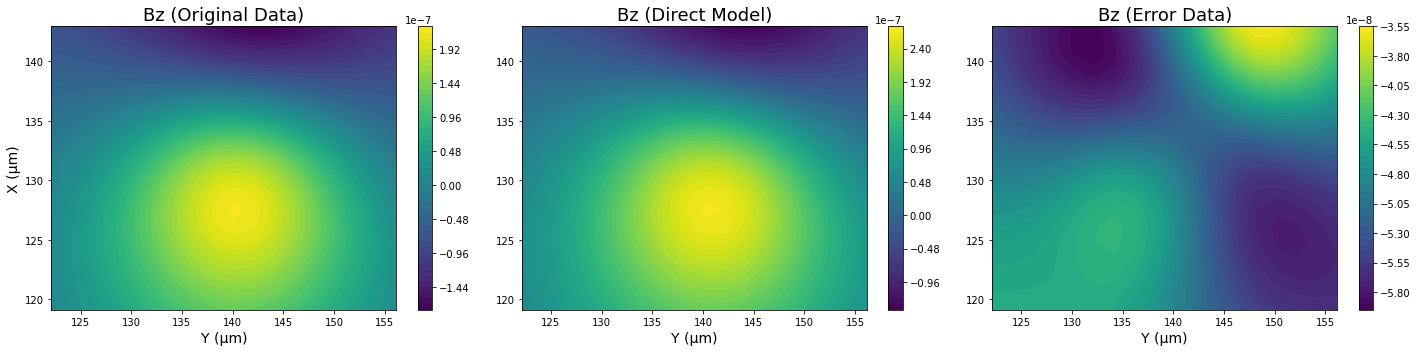

R2:  0.9215280437551685


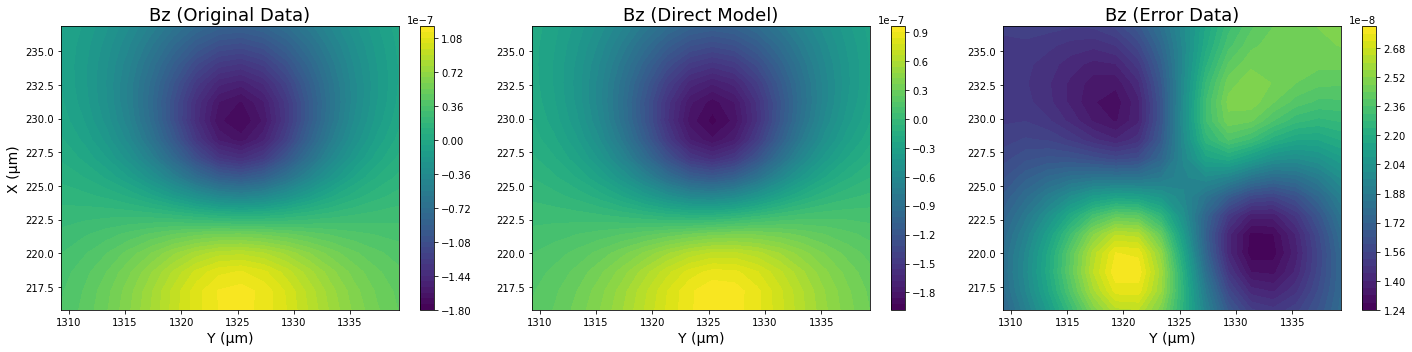

R2:  0.5381712814093027


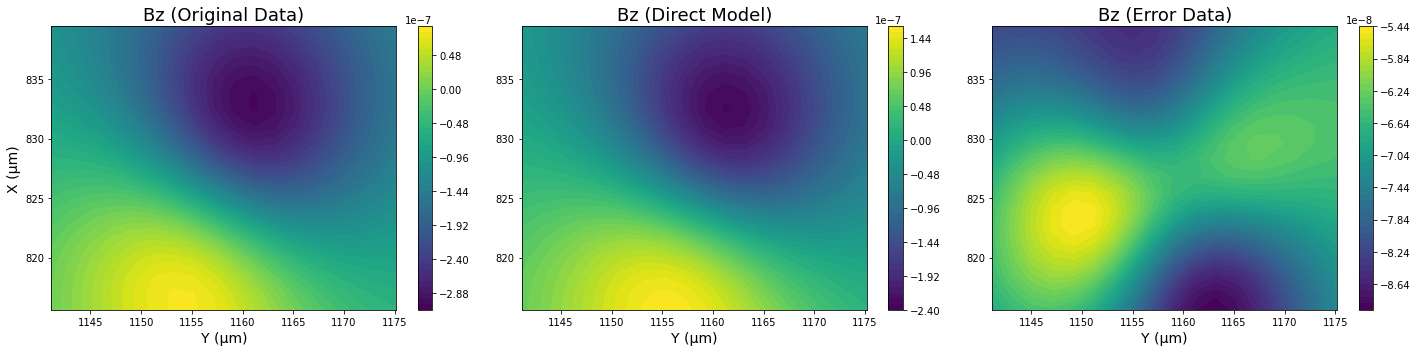

R2:  -0.7404916345585169


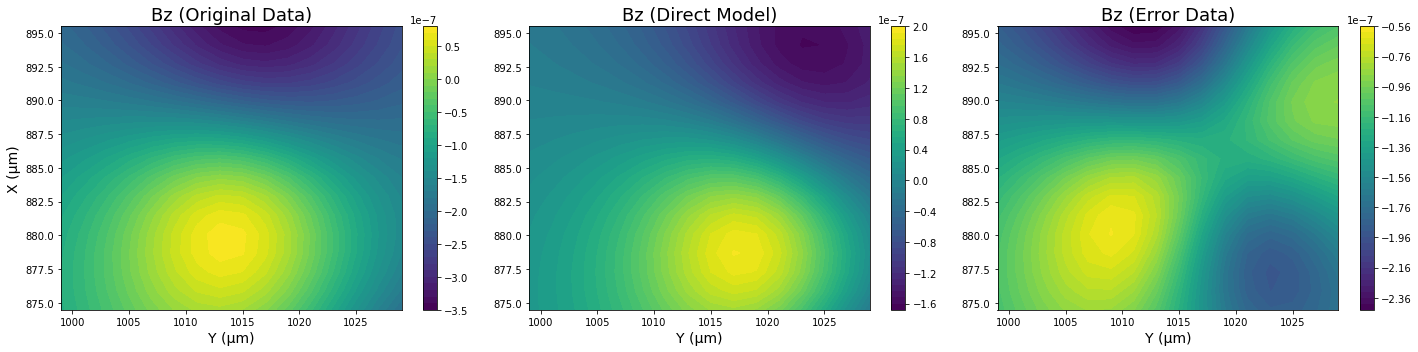

R2:  -2.3789972762876994


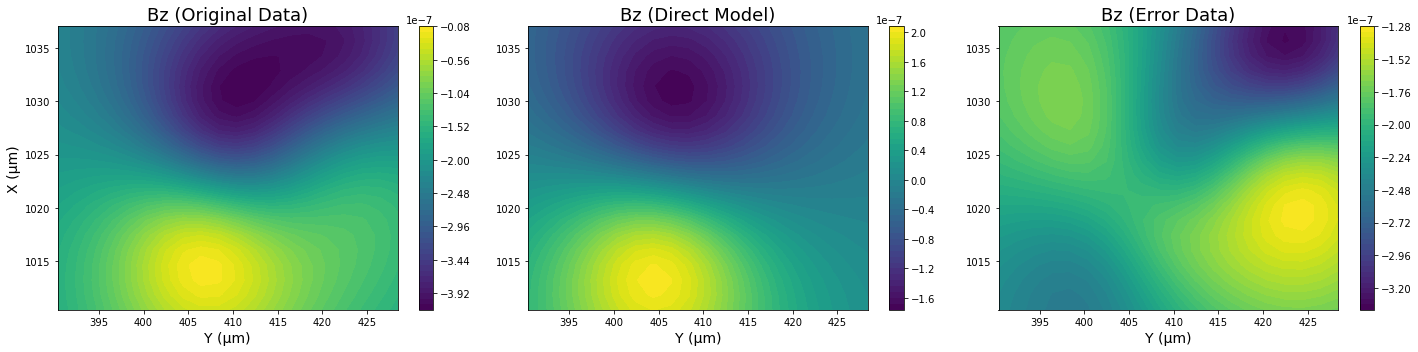

R2:  -10.530882902541403


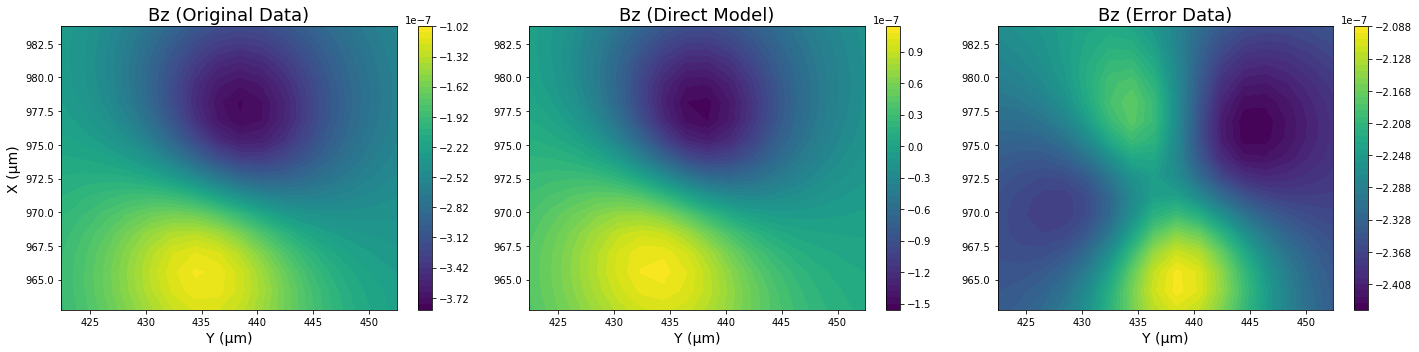

R2:  -0.3390555908326769


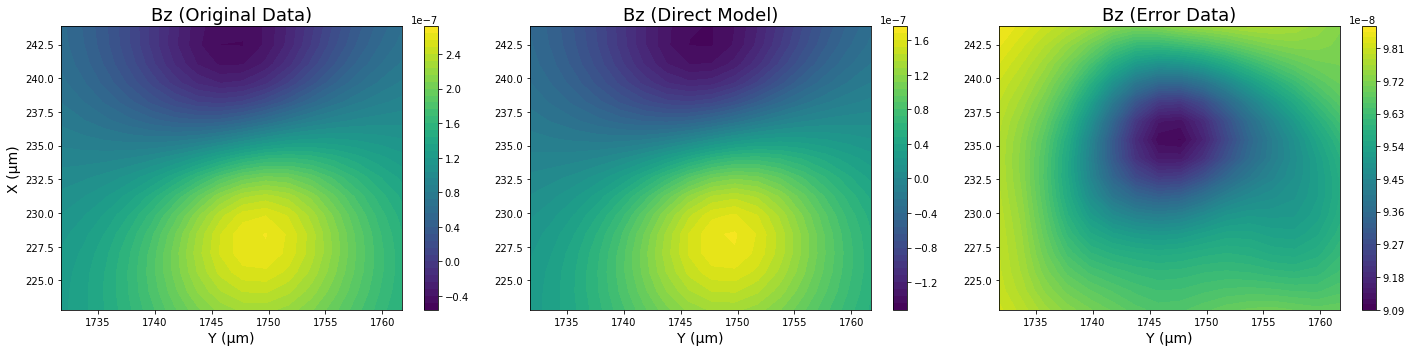

R2:  0.5481384773001947


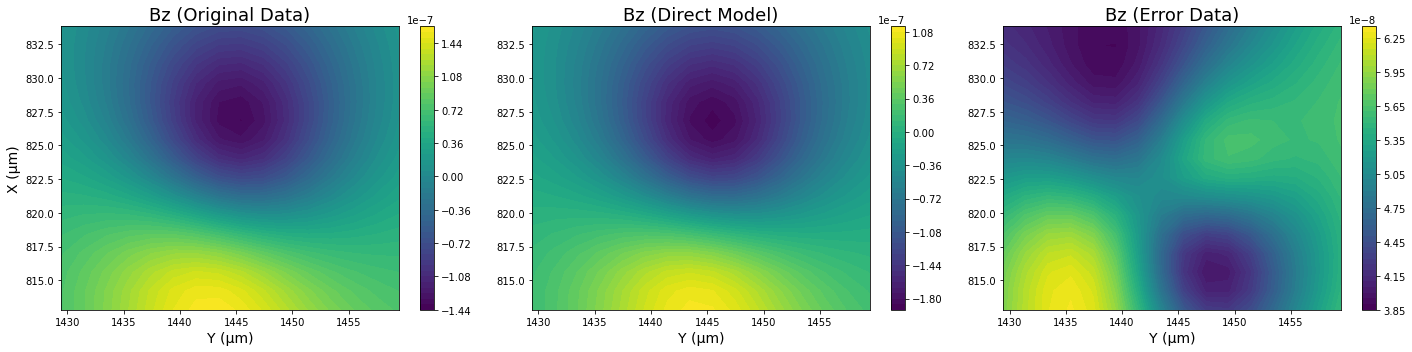

R2:  0.1922292203007192


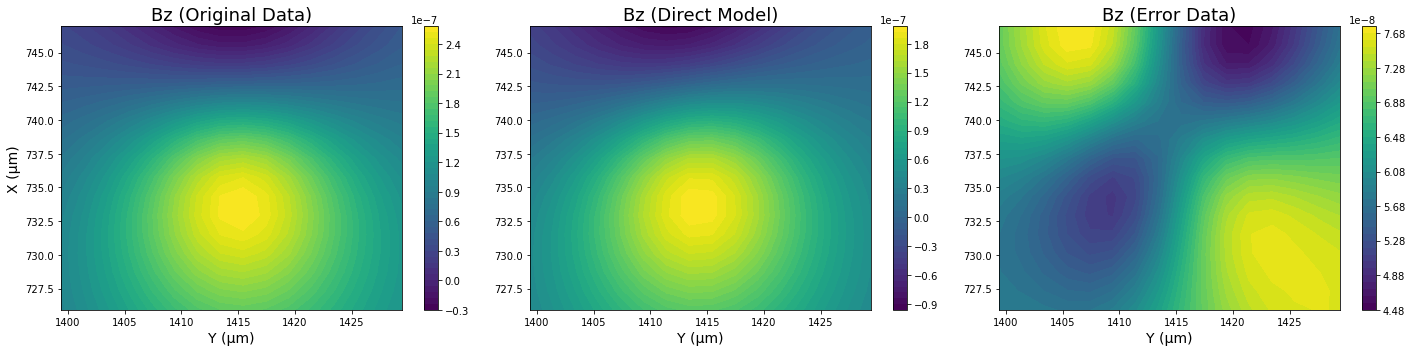

R2:  0.9961200518582339


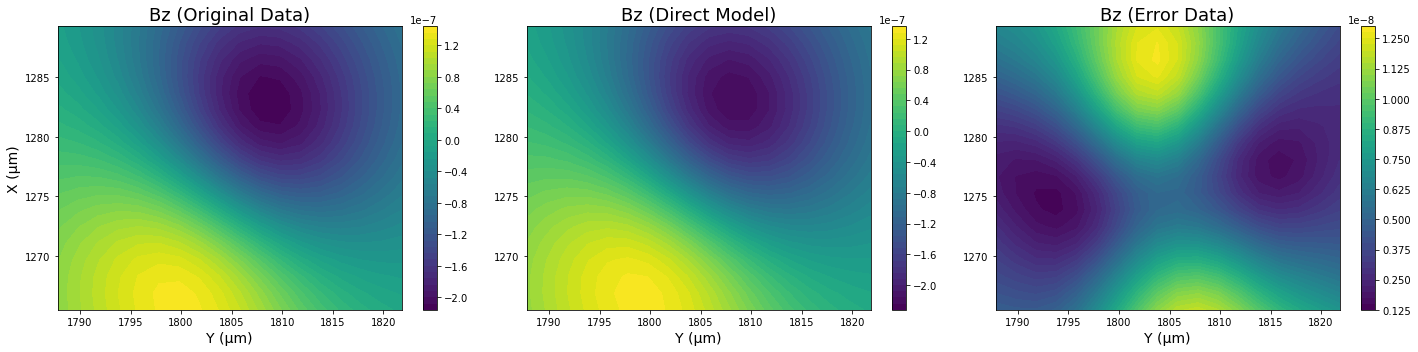

R2:  -3.745078386537024


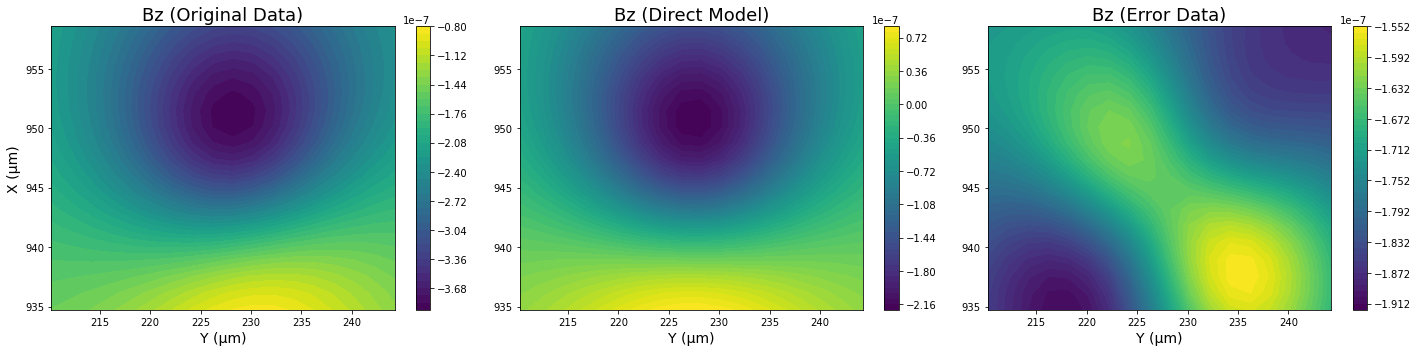

R2:  0.3882924974030586


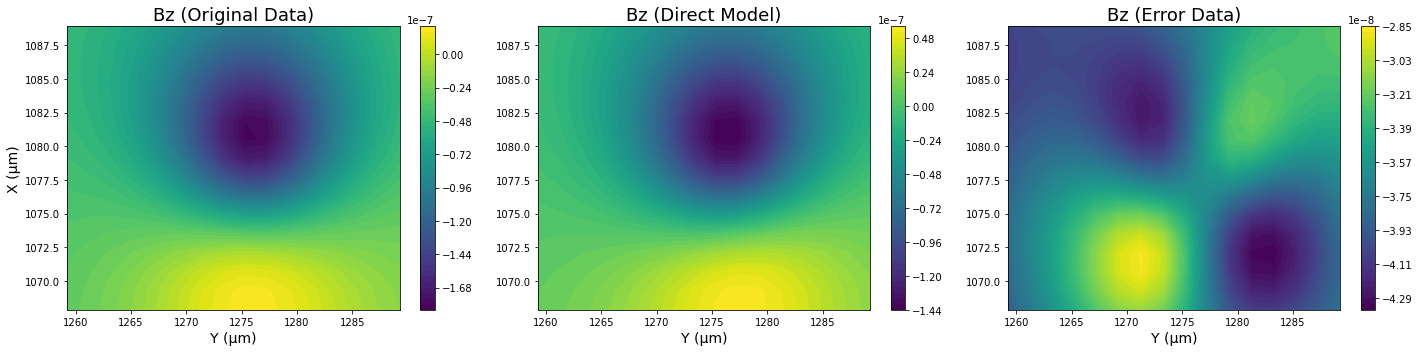

R2:  -0.647147661962056


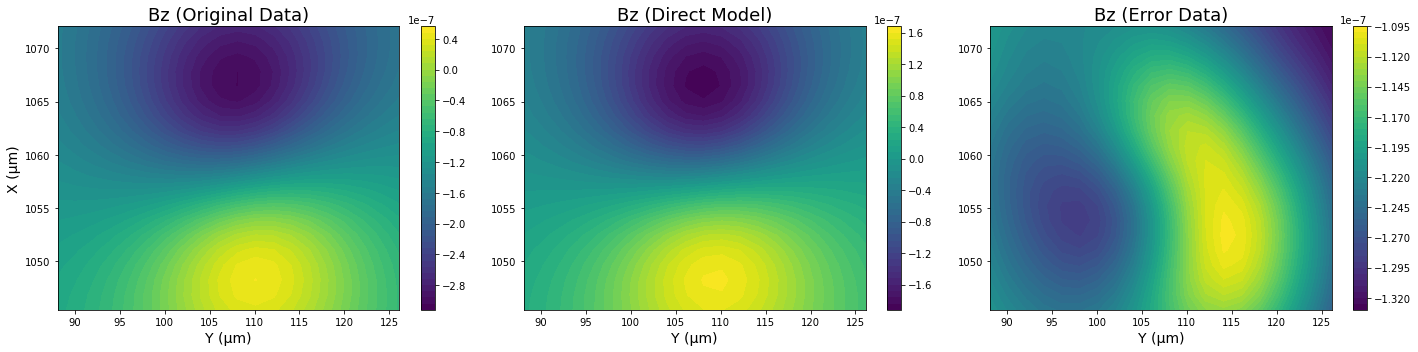

R2:  -5.043687870245778


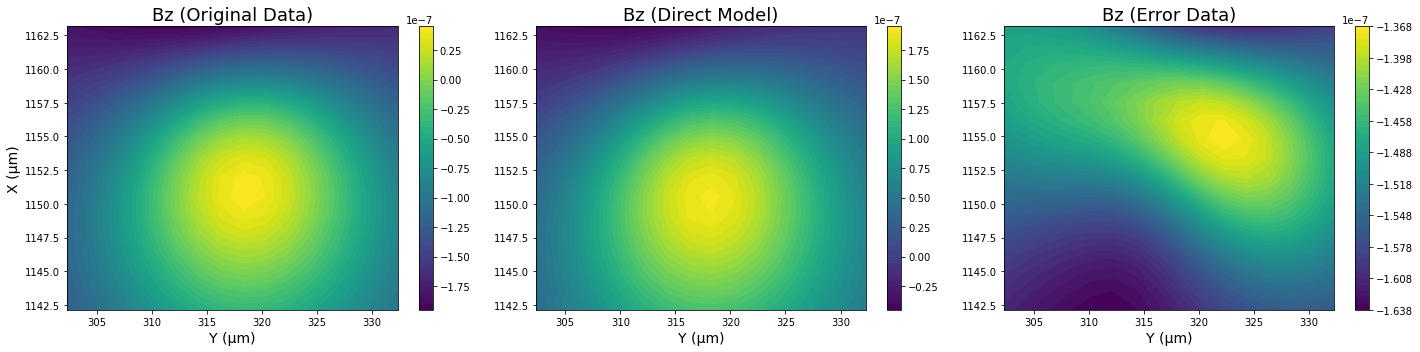

R2:  -7.110605975616295


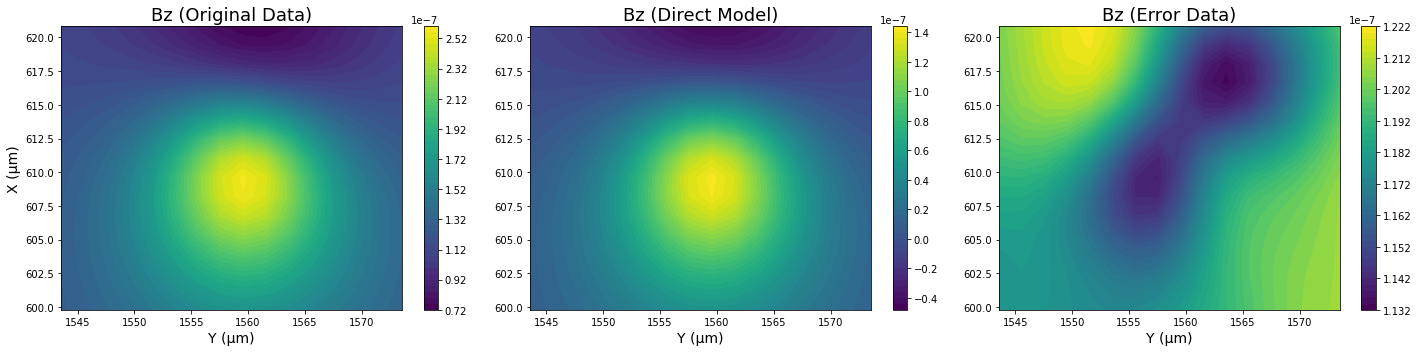

R2:  -1.4568899122181693


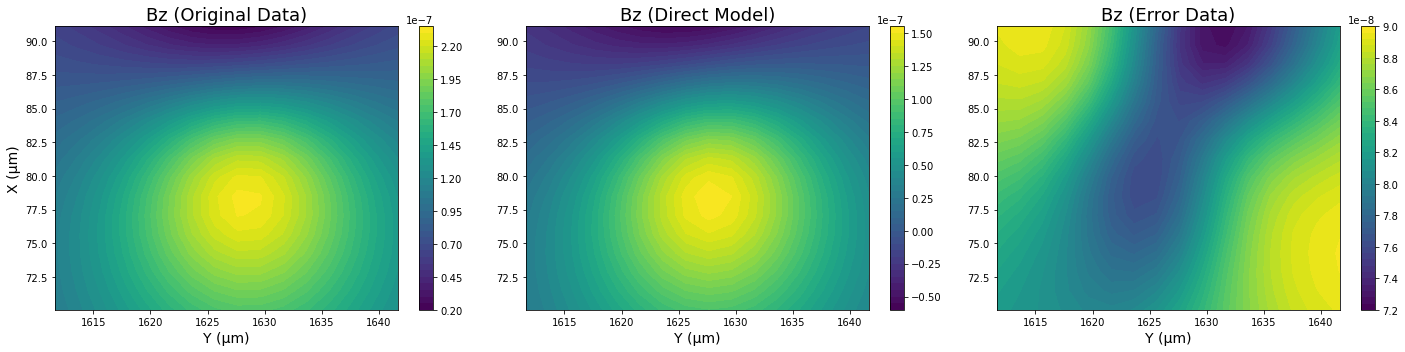

R2:  0.9066082578165165


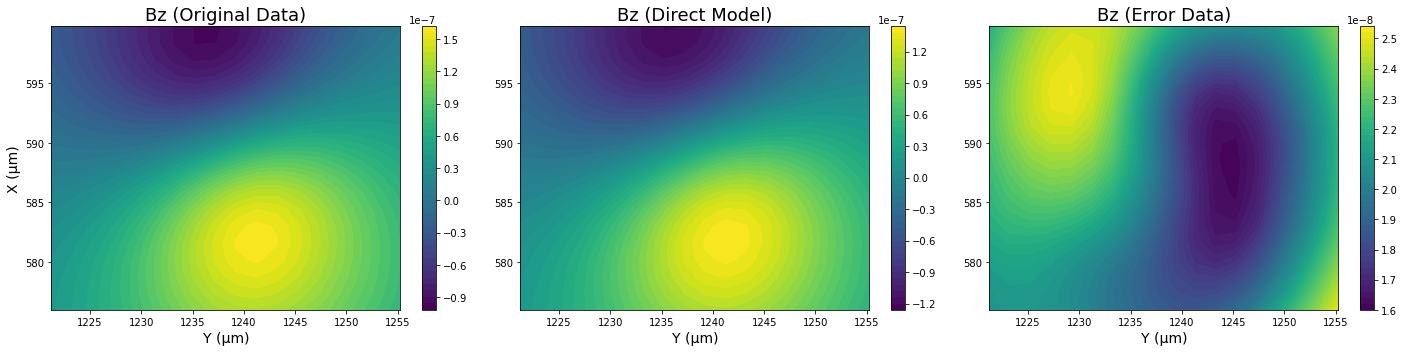

R2:  -6.2515723363953555


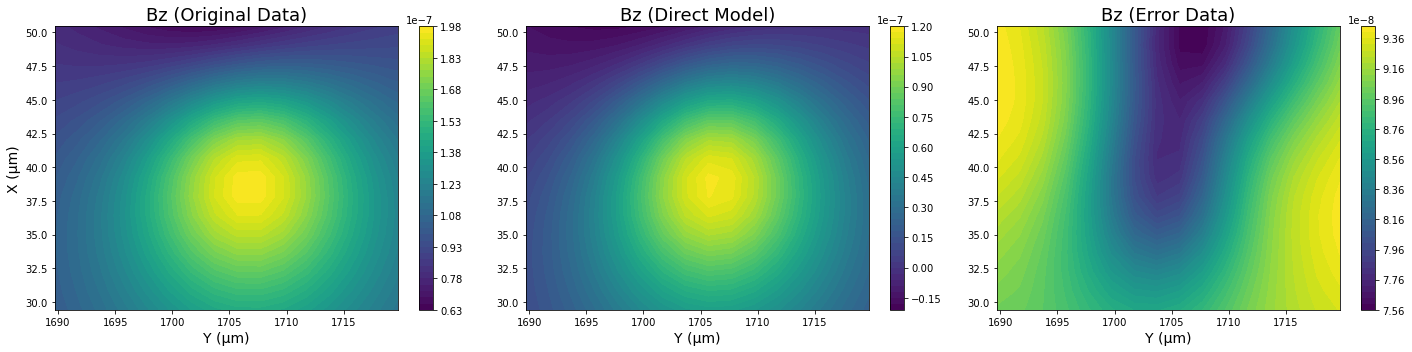

R2:  -0.6911932050210257


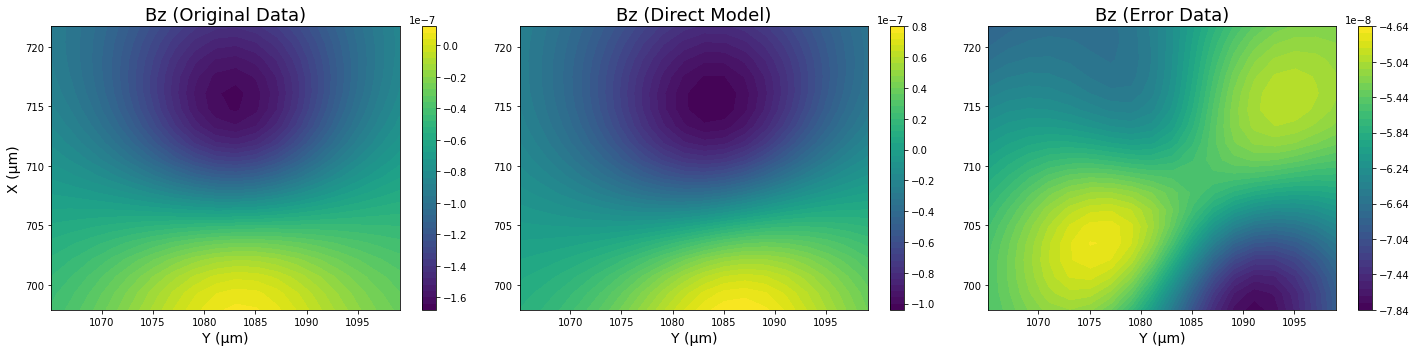

R2:  -57.08380192044446


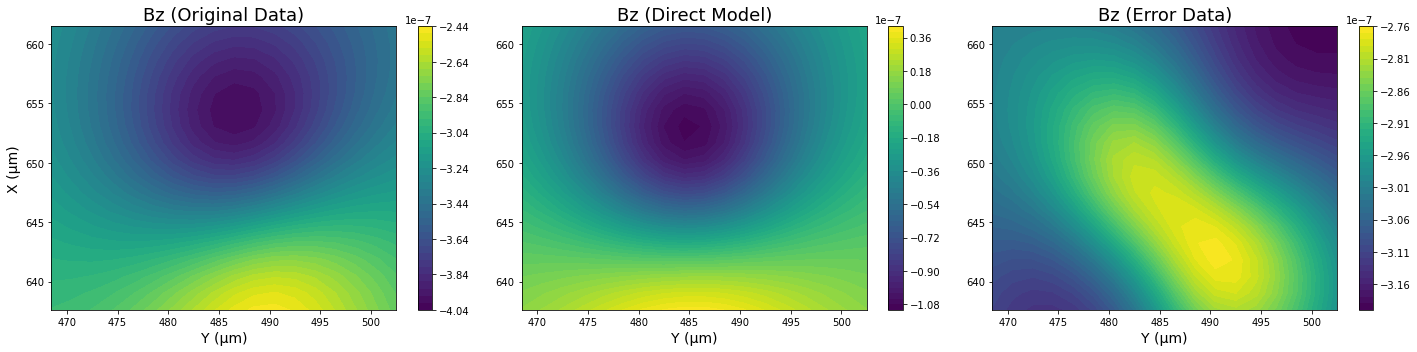

R2:  -3.5244927543215683


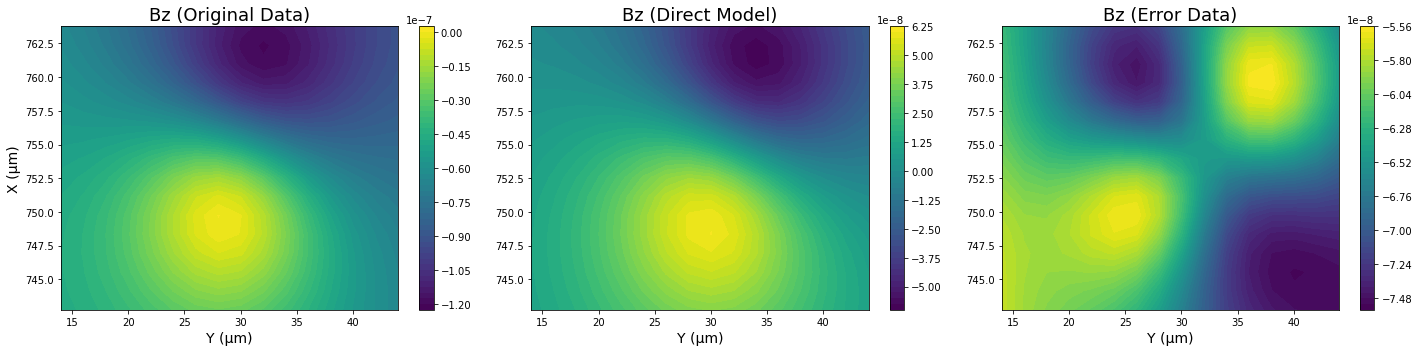

R2:  -1.7376689273010606


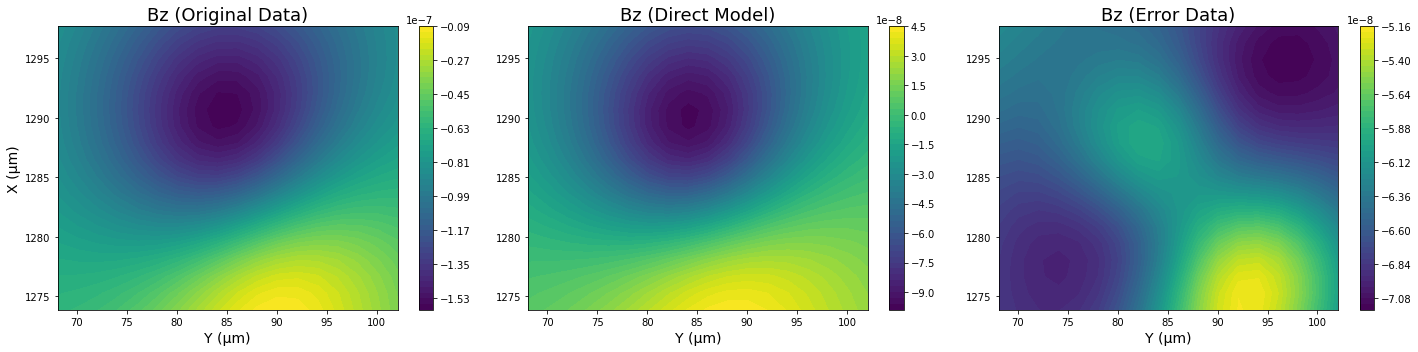

R2:  0.9397416574446047


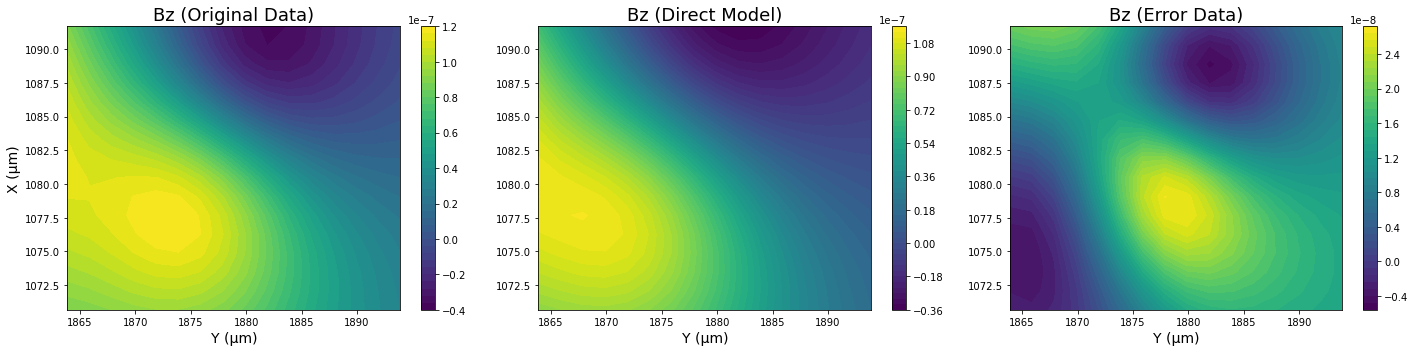

R2:  -12.425605758076292


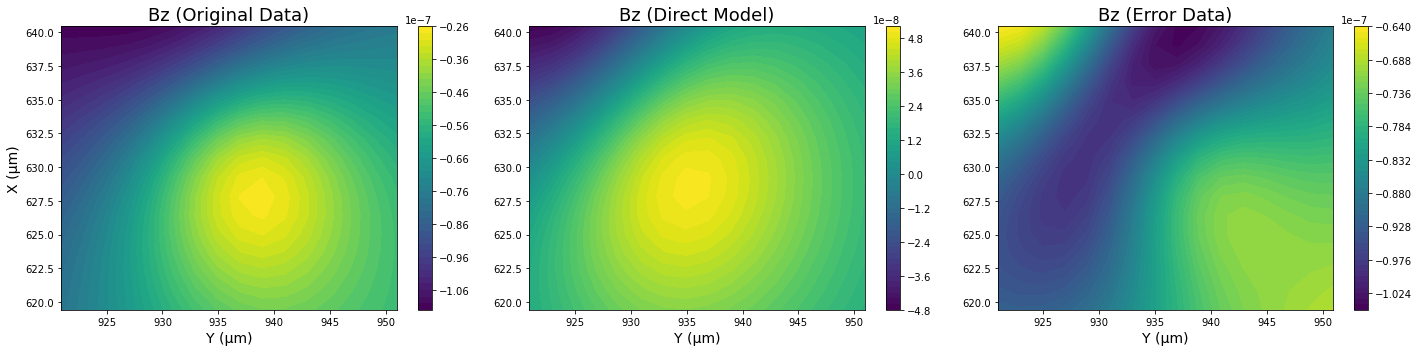

R2:  -0.09173967326878718


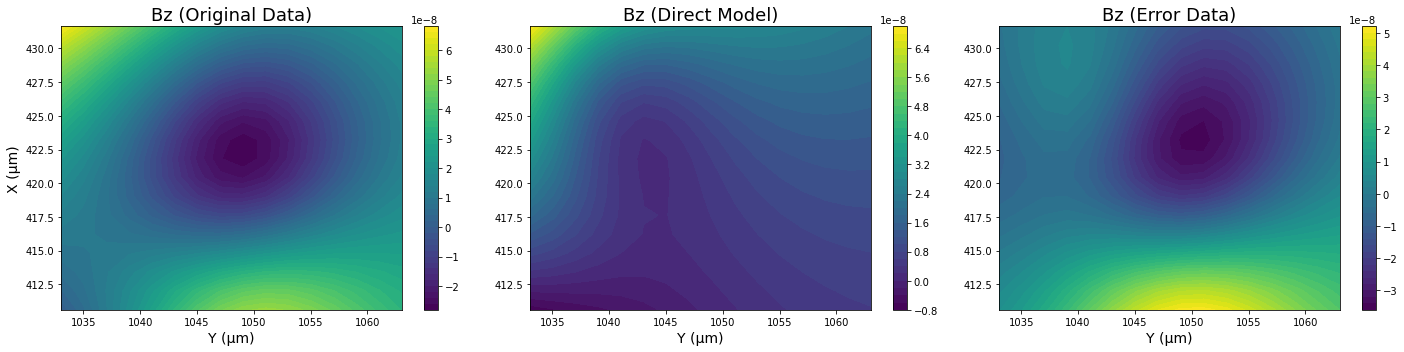

R2:  -11.59874498814275


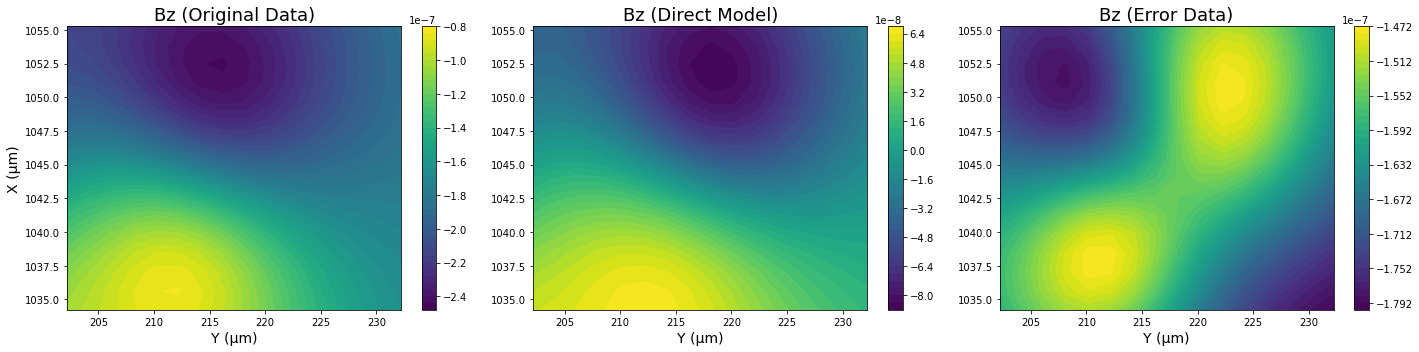

R2:  -0.9334712365501086


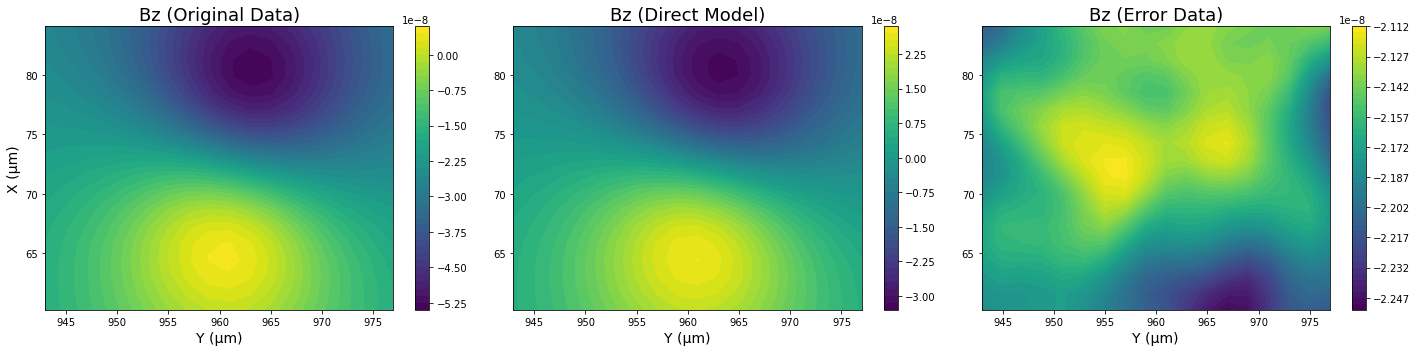

R2:  -14.44979750638163


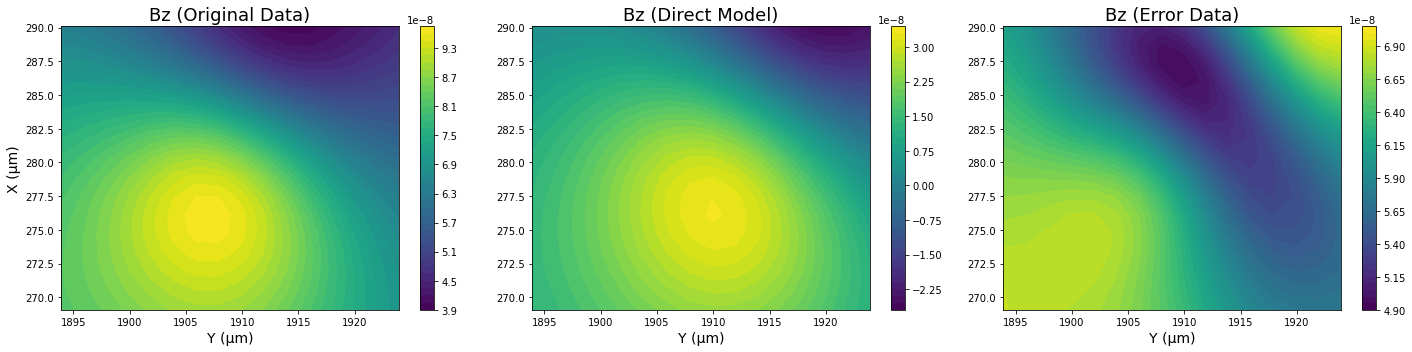

R2:  0.8268800415976324


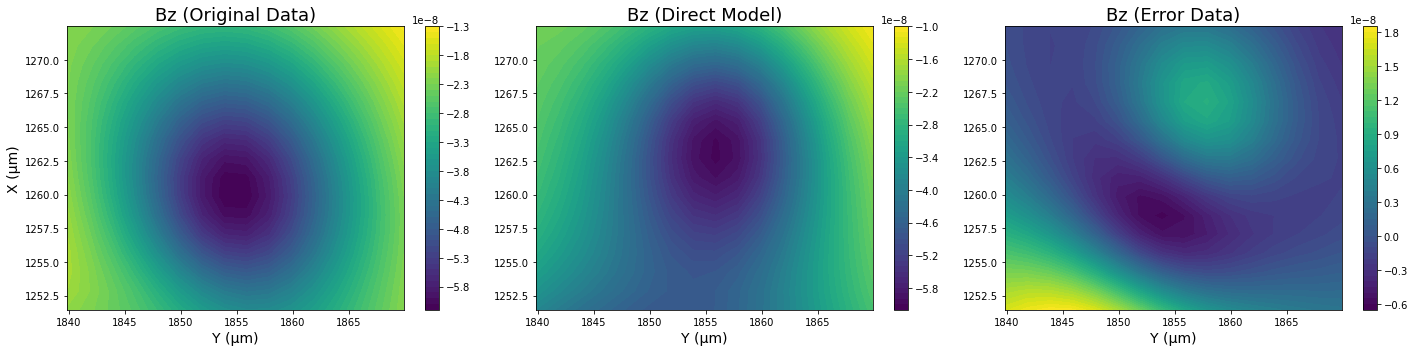

R2:  0.5065537676303522


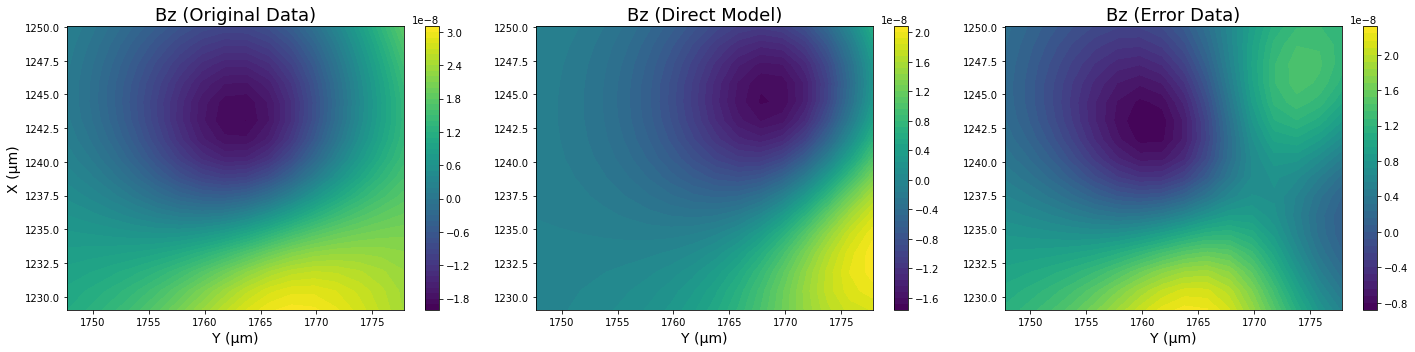

R2:  -96.26013499250716


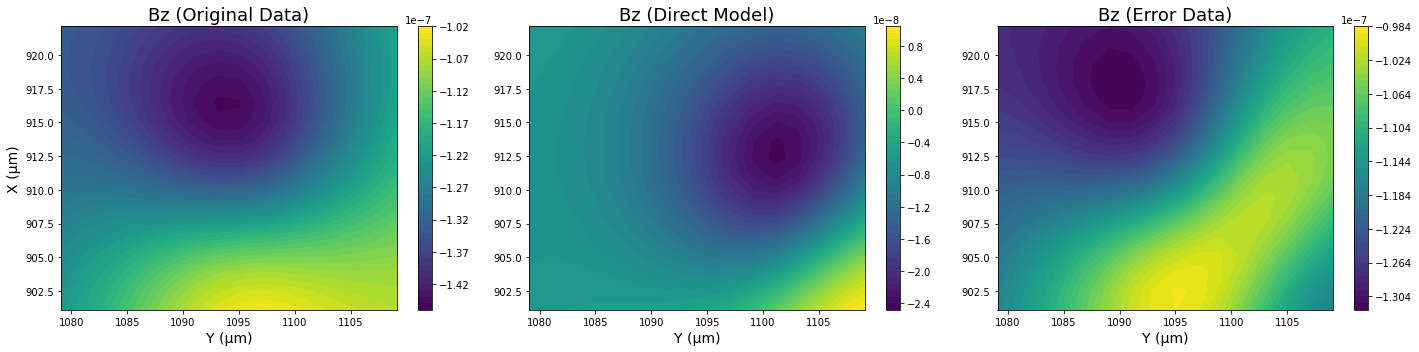

In [26]:
Xc_save, Yc_save, Zc_save = [], [], []
mx_save, my_save, mz_save = [], [], []
m_save, D_save, I_save = [], [], []
sigma_m_save, sigma_D_save, sigma_I_save = [], [], []
deter_coef_save = []

show=True


for i in range(np.shape(filtered_euler_windows_FD)[0]):
    
    if Zc_FD[i]>=0:
        x1, x2 = int(euler_windows_FD[i,0]), int(euler_windows_FD[i,1])
        y1, y2 = int(euler_windows_FD[i,2]), int(euler_windows_FD[i,3])

        data_normalized = upward[x1:x2, y1:y2]/(np.absolute(np.max(upward[x1:x2, y1:y2])
                                                         -np.min(upward[x1:x2, y1:y2])))

        model_normalized = (upward_direct_model_FD_least[x1:x2, y1:y2]/
                            (np.absolute(np.max(upward_direct_model_FD_least[x1:x2, y1:y2])
                            -np.min(upward_direct_model_FD_least[x1:x2, y1:y2]))) )

        error_normalized = data_normalized-model_normalized

        SQ_tot = np.sum( (data_normalized-np.mean(data_normalized))**2 )
        SQ_res = np.sum( (data_normalized-model_normalized)**2 )
        deter_coef = 1 - (SQ_res/SQ_tot)
        

        momentum = (np.sqrt(mx_FD_least[i]**2 + my_FD_least[i]**2 + mz_FD_least[i]**2))
        Xc_save.append(Xc_FD[i]*m2microm)
        Yc_save.append(Yc_FD[i]*m2microm)
        Zc_save.append(Zc_FD[i]*m2microm)
        mx_save.append(mx_FD_least[i])
        my_save.append(my_FD_least[i])
        mz_save.append(mz_FD_least[i])
        m_save.append(momentum)
        sigma_m_save.append(sigma_m_FD_least[i])
        D_save.append(D_FD_least[i])
        sigma_D_save.append(sigma_D_FD_least[i])
        I_save.append(I_FD_least[i])
        sigma_I_save.append(sigma_I_FD_least[i])
        deter_coef_save.append(deter_coef)

        if show:
            print('R2: ', deter_coef)

            fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

            ax1_plot = ax1.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    upward[x1:x2, y1:y2], levels=50, cmap='viridis')
            plt.colorbar(ax1_plot, ax=ax1)
            ax1.set_title('Bz (Original Data)', fontsize=18)
            ax1.set_xlabel('Y (µm)', fontsize=14)
            ax1.set_ylabel('X (µm)', fontsize=14)


            ax2_plot = ax2.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    upward_direct_model_FD_least[x1:x2, y1:y2], levels=50, cmap='viridis')
            plt.colorbar(ax2_plot, ax=ax2)
            ax2.set_title('Bz (Direct Model)', fontsize=18)
            ax2.set_xlabel('Y (µm)', fontsize=14)

            error = upward[x1:x2, y1:y2] - upward_direct_model_FD_least[x1:x2, y1:y2]
            ax3_plot = ax3.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], error, levels=50, cmap='viridis')
            plt.colorbar(ax3_plot, ax=ax3)
            ax3.set_title('Bz (Error Data)', fontsize=18)
            ax3.set_xlabel('Y (µm)', fontsize=14)

            plt.tight_layout()
            plt.show()

                    
df_final = pd.DataFrame(data={'Xc (µm)': np.array(np.round(Xc_save, decimals=4)),
                              'Yc (µm)': np.array(np.round(Yc_save, decimals=4)),
                              'Zc (µm)': np.array(np.round(Zc_save, decimals=4)),
                              'mx (Am2)': np.array(mx_save),
                              'my (Am2)': np.array(my_save),
                              'mz (Am2)': np.array(mz_save),
                              'm (Am2)': np.array(m_save),
                              'sigma m (Am2)': np.array(sigma_m_save),
                              'D (°)': np.array(D_save),
                              'sigma D (°)': np.array(sigma_D_save),
                              'I (°)': np.array(I_save),
                              'sigma I (°)': np.array(sigma_I_save),
                              'R2': np.array(deter_coef_save)

                       })

In [27]:
df_final.head(-5)
display(df_final)

Xc (µm)    Yc (µm)  Zc (µm)      mx (Am2)      my (Am2)      mz (Am2)  \
0    174.9725  1111.9955   3.1087  4.373724e-14 -1.157825e-14  3.554904e-14   
1    806.0070  1777.0263   3.1203  5.205829e-14 -2.199611e-14  1.342522e-14   
2    478.5306  1015.0640   4.3644  1.156996e-13 -5.627607e-14 -2.725205e-14   
3   1255.9865  1221.9875   1.1187  2.325279e-14 -9.121263e-15  2.048336e-15   
4    540.0164  1877.9627   1.1432  2.163586e-14  7.580804e-15 -4.437712e-15   
..        ...        ...      ...           ...           ...           ...   
89    72.9651   961.9627   6.0640  1.409488e-15  2.402845e-16 -7.612665e-17   
90   284.8123  1914.3570   9.4887  2.392933e-15  1.191842e-15  1.143384e-16   
91  1265.2748  1856.8572   6.7141 -2.802196e-16 -1.556215e-16 -1.019884e-15   
92  1240.1259  1773.1399   6.3584  8.723486e-16 -5.235238e-16 -2.327966e-16   
93   907.2077  1104.6684   6.1546  7.434579e-16 -4.103534e-16 -1.951974e-16   

         m (Am2)  sigma m (Am2)       D (°)  sigma D (°)      I (°)  \
0   5.753899e-14   4.563674e-18  -14.827394     0.006425  38.157489   
1   5.808727e-14   5.019505e-18  -22.905443     0.005158  13.363107   
2   1.315145e-13   6.693631e-18  -25.938198     0.003013 -11.959313   
3   2.506163e-14   2.883970e-18  -21.418354     0.006626   4.688126   
4   2.335107e-14   2.885515e-18   19.309514     0.007278 -10.955307   
..           ...            ...         ...          ...        ...   
89  1.431848e-15   9.438738e-18    9.674574     0.378495  -3.047666   
90  2.675759e-15   1.619079e-17   26.476405     0.347188   2.449063   
91  1.069067e-15   7.818230e-18 -150.954161     1.894448 -72.552933   
92  1.043678e-15   9.841668e-18  -30.969291     0.561230 -12.888476   
93  8.713332e-16   9.479453e-18  -28.896612     0.647772 -12.945345   

    sigma I (°)         R2  
0      0.004199   0.998921  
1      0.003642   0.991609  
2      0.002129   0.995322  
3      0.004686   0.998088  
4      0.005143   0.990360  
..          ...        ...  
89     0.267642  -0.933471  
90     0.245491 -14.449798  
91     0.554928   0.826880  
92     0.396055   0.506554  
93     0.457464 -96.260135  

[94 rows x 13 columns]

### Filtering data by: deternation coef. (R$^2$), $\sigma$D and $\sigma$I 

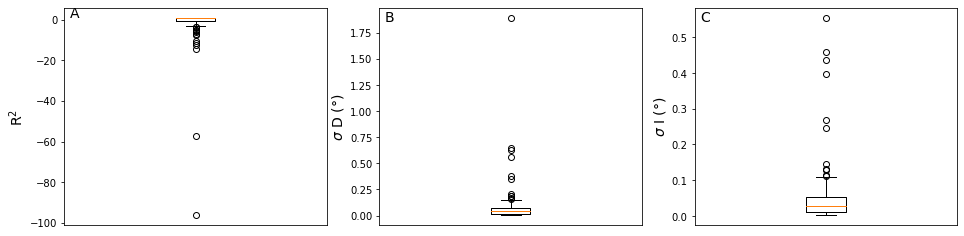

In [28]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
axes[0].boxplot(df_final['R2'])
axes[0].set_xticks([])
axes[0].set_ylabel('R$^2$', fontsize=14)
ytext = df_final['R2'].max()
axes[0].text(0.52, ytext-0.02*ytext, 'A', fontsize=14)

axes[1].boxplot(df_final['sigma D (°)'])
axes[1].set_xticks([])
axes[1].set_ylabel('$\sigma$ D (°)', fontsize=14)
ytext = df_final['sigma D (°)'].max()
axes[1].text(0.52, ytext-0.02*ytext, 'B', fontsize=14)

axes[2].boxplot(df_final['sigma I (°)'])
axes[2].set_xticks([])
axes[2].set_ylabel('$\sigma$ I (°)', fontsize=14)
ytext = df_final['sigma I (°)'].max()
axes[2].text(0.52, ytext-0.02*ytext, 'C', fontsize=14)

plt.show()

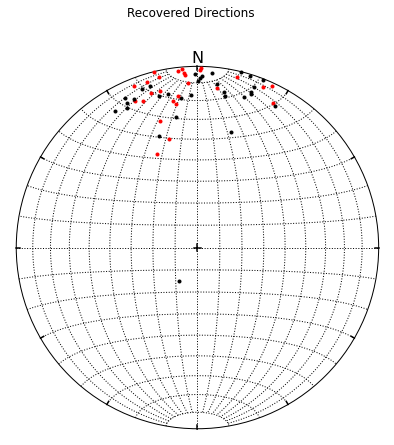

In [42]:
index = ((df_final['R2']>=0.5) & (df_final['sigma D (°)']<=5) & (df_final['sigma I (°)']<=3))
h=df_final[index]



D, I = directions(np.array(h['mx (Am2)']), np.array(h['my (Am2)']), np.array(h['mz (Am2)']), plot=True, show_mean=False, show_alpha95=False)

#### Momentum Recovered

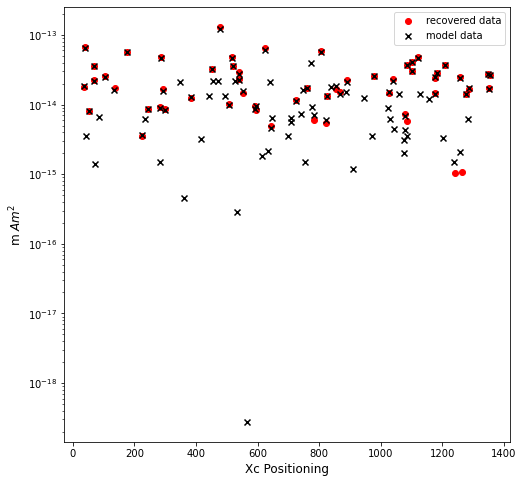

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(h['Xc (µm)'], h['m (Am2)'], label='recovered data', color='r')

m_real = Q_1*4/3*np.pi*R_1**3
plt.scatter(Xc_1*m2microm, m_real, marker='x', label='model data', color='k')
plt.yscale('log')

plt.xlabel('Xc Positioning', fontsize=12)
plt.ylabel('m $Am^{2}$', fontsize=12)

plt.legend(loc='best')